# Pairs Trading Enhancements

By Sam Galita and James Zhang |  Smith Investment Fund  |  Spring 2023

<hr/>

# Introduction

Pairs trading is a type of mean reversion trading strategy first introduced by technical analyst researchers at Morgan Stanley in the mid-1980s. On a high level, pairs trading involves matching a long position with a short position in two highly cointegrated stocks. A statistical tool often used in timeseries analysis, cointegration measures the degree to which two time series' means trend together. In pairs trading, we apply cointegration on the difference of prices between two stocks, otherwise known as the spread, to detect assets that tend to trend similarly. One of the main advantages of this strategy is market neutrality. Since traders are trading the spread between two assets and not individual assets, a pairs trader can find statistical arbitrage opportunities regardless of market direction. In other words, we should not expect better or worse performance during economic downswings. Furthermore, traders remain delta neutral when using this strategy, making pairs trading relatively low risk, and theoretically less volatile than a market-following strategy. As a result of this risk advantage, many hedge funds have historically leveraged pairs trading, despite it's low relative returns. However, this strategy is widely known in the modern market and would likely not provide high returns in a real market setting. Despite this, pairs trading sets the groundwork for further research into statistical arbitrage and remains an interesting topic for research.
After two cointegrated stocks are identified, if a cointegration discrepancy occurs - when the spread between two securities diverges from their historical rolling mean and beyond some threshold - the trader invests a dollar-matched long position in the underperforming security and short position in the overperforming security. If the spread between these assets does indeed reconverge, which is expected due to the identified relationship between pairs, traders will make a profit.
One of the keys to successful Pairs Trading is being able to efficiently detect pairs. In a notebook published a few months ago, Abhi designed and applied a basic pais trading strategy to the equity and crypto markets. In our notebook, We propose enhancements to last semester's Pairs Trading work done by Abhi. First, we will apply Principal Component Analysis (PCA) and clustering to the pricing timeseries', exploring a variety of clustering methods in the process. Within each cluster, we will then perform cointegration tests to identify pairs. Because of the use of clustering and PCA, we expect to find a reduction in needed computation time, thus allowing us to use a larger universe size when backtesting, which theoretically will allow us to compute more profitable pairs. Furthermore, we will also explore a variety of parameter optimizations for the strategy, specifically with respect to lookback, reset frequency of pair selection, and zscore cutoffs. Lastly, we will also explore the idea of using the hurst exponent as an additional criteria when selecting pairs.


## Required Imports

Below is some more information about some of the more fundamental libraries if you want to learn more.

- <a href="https://numpy.org/doc/">NumPy</a>
- <a href="https://pandas.pydata.org/docs/">Pandas</a>
- <a href="https://matplotlib.org/stable/index.html">Matplotlib</a>
- <a href="https://scikit-learn.org/stable/index.html">Sklearn</a>
- <a href="https://www.statsmodels.org/stable/index.html">Statsmodels</a>

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import ticker
import math
import statsmodels
import sklearn
import random
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from statsmodels.tsa.stattools import coint
import seaborn as sns
from IPython.core import display as ICD
import csv
import collections
from collections import OrderedDict, Counter
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union
array_1d = Union[List, Tuple, pd.Series, np.ndarray]
date_obj = Union[datetime.datetime, datetime.date]
import requests
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import bs4 as bs
import functools
from hyperopt import hp
import ray
from ray import tune
import logging

import warnings
warnings.filterwarnings('ignore')  # Disable warnings to reduce output spam in notebook

from sif.siftools.backtesters import full_backtesters as fb
from sif.siftools import operators as op
from sif.siftools import metrics as metrics
from sif.sifinfra import sif_utils as su
from sif.siftools.abstractalpha import AbstractAlpha
from sif.sifinsights import alpha_search
from sif.sifinsights.alpha_search import apply_metric_func

We initialize multiple backtesters from the SIF Infrasture that will allow us to test our Pairs Trading Strategies in sample from 2000-2015 and out of sample from 2016-2020. Note that we can save them locally to save time each time we want to test our alphas.

In [2]:
# *** IN SAMPLE BACKTESTER WITH UNIVERSE REBALANCING *** #
start_date_15y = datetime.datetime(2000, 1, 1)
end_date_15y = datetime.datetime(2015, 12, 31)
# backtester_15y = fb.FullMultipleBacktester(
#     start_date_15y,

#     end_date_15y,
#     'M',
#     273,
#     universe_size = 500, 
#     factors=['close', 'sector']
# )

# backtester_15y.save_local('pairs_15y.npy')
backtester_15y = fb.FullMultipleBacktester.from_local('sif\pairstrading\pairs_15y.npy')
sp_data = su.get_sp_close(start_date_15y, end_date_15y)  # Also pull S&P data for use later
sp_ret = sp_data.pct_change()

In [3]:
# *** OUT OF SAMPLE BACKTESTER WITH UNIVERSE REBALANCING *** #
start_date_5y = datetime.datetime(2016, 1, 1)
end_date_5y = datetime.datetime(2020, 12, 31)
# backtester_5y = fb.FullMultipleBacktester(
#     start_date_5y,
#     end_date_5y,
#     'M',
#     273,
#     universe_size = 500, 
#     factors=['close', 'sector']
# )

# backtester_5y.save_local('pairs_5y.npy')
backtester_5y = fb.FullMultipleBacktester.from_local('pairs\pairs_5y.npy')

In [3]:
# *** GET ROLLING SHARPE RATIO HELPER FUNCTION *** #
def get_rolling_sharpe(returns):
    rolling_sharpe = functools.partial(metrics.rolling_metric, func=metrics.sharpe_ratio, window=252)
    returns.apply(rolling_sharpe).plot()
    plt.title('1 Year Rolling Sharpe Ratio')
    plt.show()

# *** GET OTHER SUMMARY ANALYTICS HELPER FUNCTION *** #
def get_analytics(alphas, returns, holdings):
    perf_tables = apply_metric_func(metrics.generate_performance_table, ('daily_returns', 'holdings'))(returns, holdings)
    for alpha, table in zip(alphas, perf_tables):
        print(f"{alpha.name}")
        ICD.display(table)
        print()

## Previous Work and Novelties

SIF Researcher Abhinav Modugula worked on Pairs Trading for much of last semester. Our work in this notebook builds on top of his initial research. You can read his work here: https://www.smithinvestmentfund.com/blog/crypto-pairs-trading. His initial work on Pairs Trading should be read before the rest of this notebook.

### Selecting Pairs and Weights

As a baseline metric, we present brute force pairs trading alphas without dimensionality reduction, machine learning enhancements, additional trading criteria, or parameter optimization. These alphas are based off of Abhi's original alphas, with notable fixes to certain bugs.

For both of the following alphas, we test for cointegration between the price time series of two securities using the `Statsmodels` implementation of the Engel-Granger Test, which outputs a pvalue that can be used to either accept or reject the null hypothesis that the two secrities are cointegrated. The first alpha takes all of the statistically significant pairs between the 500 securities in the universe and randomly selects 10 to trade off of. Extracting random pairs out of all the generated pairs can possibly be improved, however, by choosing the lowest pvalue pairs. The second alpha implements this idea. 


See the implementation below of the Random pairs trading strategy explained in the introduction. The lowest pvalue strategy can be found in the alphas.py file.

### Parameters

For this inital strategy, we rechoose pairs every 90 days and select 10 pairs to trade on. The universe size is 500, and we enter trades when the magnitude of the zscore of the difference of prices is above 1.5 and exit when it is below 1.0

In [ ]:
class Random(abstractalpha.AbstractAlpha):
    def __init__(self, reset, npairs, exit):
        self.name = 'Random'
        self.lookback = reset
        self.factor_list = ['close']
        self.universe_size = 500
        
        self.pairs = None
        self.print = True
        self.reset = reset
        self.npairs = npairs
        self.exit = exit
        self.holdings = np.zeros(self.universe_size)
        self.day_counter = 0
        self.count = 0
    
    def form_pairs(self, df):
        df = pd.DataFrame(df)
        n = df.shape[1]
        
        # creating an adjacency matrix sort of for cointegration scores and pvalues
        pvalue_matrix = np.ones((n, n))
        keys = df.keys()
        pairs = []
        for i in range(50):
            for j in range(i + 1, 50):
                S1 = df[keys[i]]
                S2 = df[keys[j]]
                coint_df = pd.DataFrame({'S1': S1, 'S2': S2}).dropna()
                S1 = coint_df['S1']
                S2 = coint_df['S2']
                result = coint(S1, S2)
                pvalue = result[1]
                pvalue_matrix[i, j] = pvalue
                if pvalue < 0.05 and pvalue != 0:
                    pairs.append([i, j])
        
        # a stock should only be included once in our holdings to prevent mishaps
        new_pairs, seen = [], set()
        for (i, j) in pairs:
            if i not in seen and j not in seen:
                new_pairs.append([i, j])
                seen.add(i)
                seen.add(j)

        new_pairs = new_pairs if len(new_pairs) < self.npairs else random.sample(new_pairs, self.npairs)
        return new_pairs
    
    def zscore(self, series: array_1d) -> float:
        return (series - series.mean()) / np.std(series)
        
    def generate_day(self, day, data):
        
        # creating new pairs
        if self.day_counter == 0:
            self.day_counter = self.reset
            self.holdings = np.zeros(self.universe_size)
            self.pairs = self.form_pairs(data['close'])
      
        data = pd.DataFrame(data['close'])
        global ex_data
        if self.print:
            ex_data = data
            self.print = False

        for p in self.pairs:
            # FIRST and SECOND are indices of the stocks
            FIRST, SECOND = p[0], p[1]
            spread = data[FIRST] - data[SECOND]
            
            #zscore tells us how far from away from the mean a data point is
            z_score = self.zscore(spread).tail(1).values[0]
            
            if z_score >= 1.0:
                self.holdings[FIRST] = -1
                self.holdings[SECOND] = 1
                
            # exit the trade
            elif abs(z_score) <= self.exit:
                self.holdings[FIRST] = 0
                self.holdings[SECOND] = 0

            # enter the trade; long the FIRST, short SECOND
            elif z_score <= -1.0:
                self.holdings[FIRST] = 1
                self.holdings[SECOND] = -1
            
        # at the end of the trading day, decrement day_counter
        self.day_counter -= 1
        return op.weight(self.holdings)

# Brute force Random Alphas

Done!: 100%|██████████| 2/2 [08:50<00:00, 265.28s/it]        


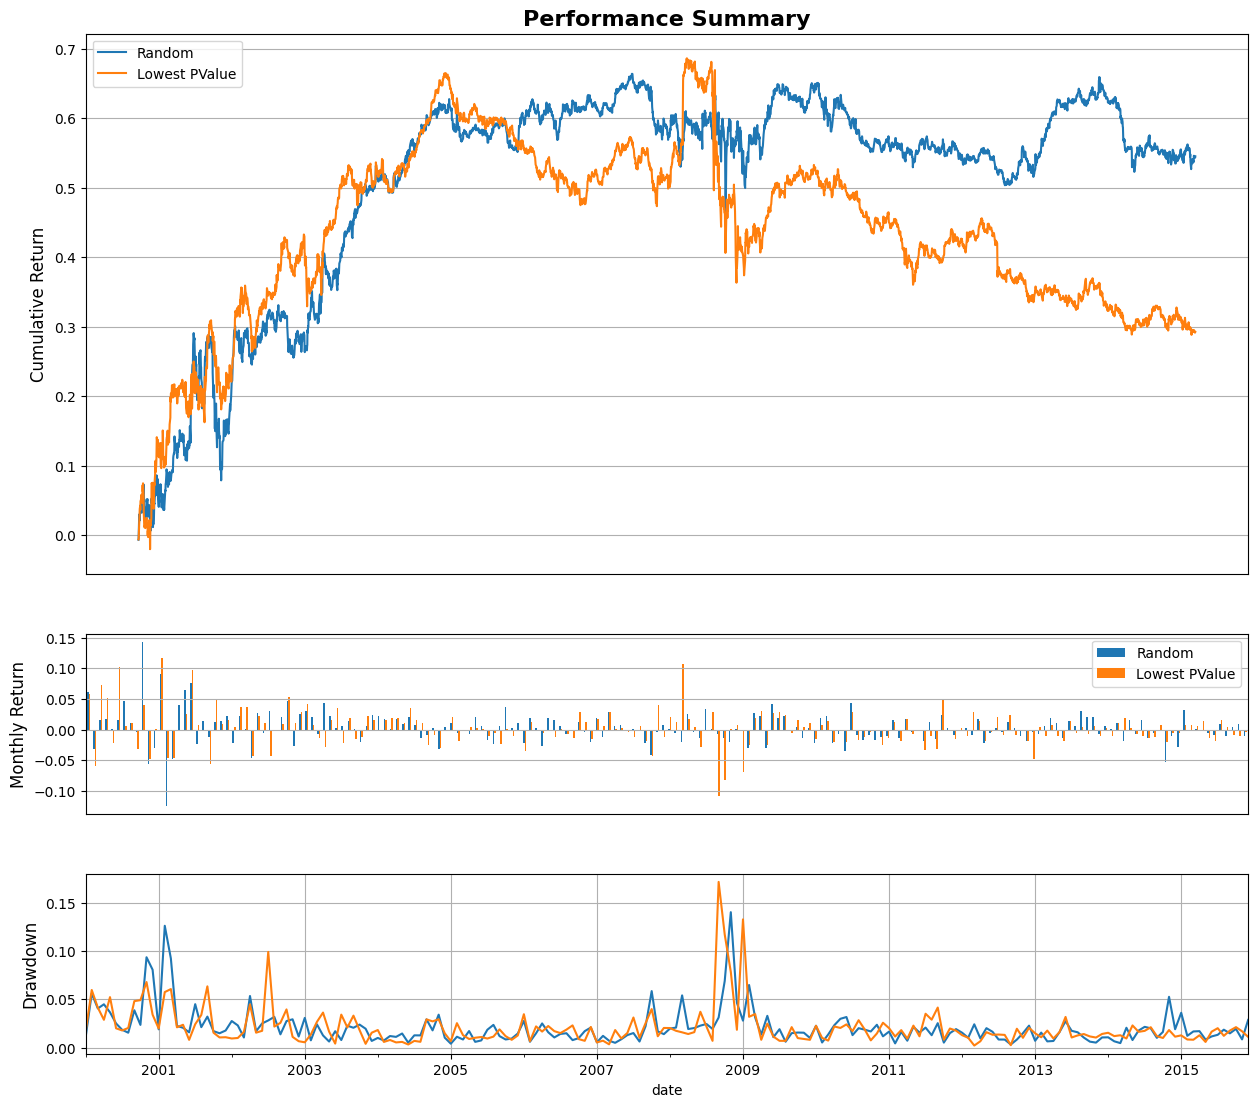

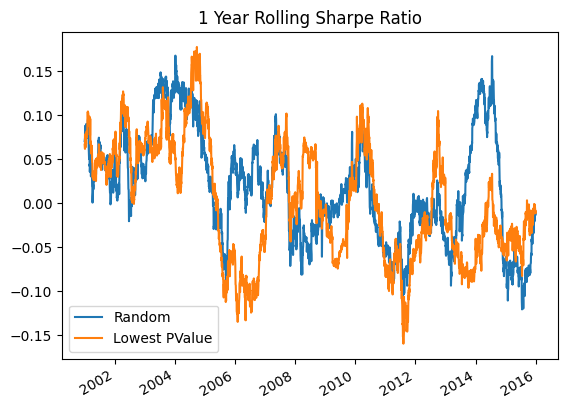

Random


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.186652  1.114974  1.791552  0.106303  0.212229    7.642857   
2001     0.128310  0.803249  1.033410  0.194085  0.206014    6.983871   
2002     0.068493  0.647088  1.127973  0.073131  0.182813    7.722222   
2003     0.142431  2.031832  3.217764  0.038600  0.209547    7.123016   
2004     0.047416  0.783313  1.184474  0.059674  0.190474    7.150794   
2005     0.040945  0.808288  1.338758  0.047482  0.166779    7.400794   
2006    -0.011988 -0.229162 -0.404678  0.052406  0.187039    7.573705   
2007    -0.013777 -0.249808 -0.374430  0.091118  0.181410    7.820717   
2008    -0.020552 -0.121151 -0.199020  0.170543  0.190999    7.351779   
2009     0.062143  0.587555  0.852673  0.093261  0.192943    7.349206   
2010    -0.067975 -0.950013 -1.429325  0.086694  0.183116    7.361111   
2011    -0.004123 -0.086405 -0.132938  0.044257  0.185676    7.805556   
2012    -0.035464 -0.792704 -1.186212  0.046621  0.172227    7.752000   
2013     0.096880  1.743701  3.141995  0.043544  0.186229    7.297619   
2014    -0.062708 -1.114161 -1.489714  0.103087  0.171764    7.960317   
2015    -0.011752 -0.192646 -0.248210  0.048511  0.176341    7.694444   
Overall  0.544931  0.362244  0.502917  0.201399  0.228246    7.499627   

         short count  
year                  
2000        6.642857  
2001        5.983871  
2002        6.722222  
2003        6.123016  
2004        6.150794  
2005        6.400794  
2006        6.573705  
2007        6.820717  
2008        6.351779  
2009        6.349206  
2010        6.361111  
2011        6.805556  
2012        6.752000  
2013        6.297619  
2014        6.960317  
2015        6.694444  
Overall     6.499627


Lowest PValue


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.180812  1.053725  1.829786  0.091796  0.226467    7.507937   
2001     0.165941  1.205343  2.029064  0.122297  0.189301    7.391129   
2002     0.123606  1.104666  1.592907  0.099279  0.146042    7.543651   
2003     0.064861  0.897984  1.182229  0.056446  0.209896    6.686508   
2004     0.058690  1.171208  2.209314  0.069795  0.200735    7.761905   
2005    -0.047359 -0.941021 -1.813974  0.072203  0.142387    8.182540   
2006    -0.039646 -0.733005 -1.262911  0.067657  0.179331    7.669323   
2007     0.008311  0.136990  0.223395  0.095579  0.180054    7.693227   
2008    -0.025444 -0.111519 -0.137161  0.258376  0.158513    7.573123   
2009     0.034336  0.288522  0.363558  0.133044  0.149991    7.305556   
2010    -0.065584 -1.198455 -1.727698  0.073577  0.203554    7.099206   
2011    -0.057343 -0.932232 -1.531600  0.101018  0.168359    8.142857   
2012     0.018511  0.373819  0.586937  0.037820  0.185738    7.236000   
2013    -0.076918 -1.146782 -1.131765  0.049826  0.162519    7.908730   
2014    -0.041533 -0.785514 -1.196998  0.072838  0.151182    8.095238   
2015    -0.008827 -0.179263 -0.303611  0.041806  0.172302    8.353175   
Overall  0.292415  0.180952  0.237205  0.352767  0.221043    7.634783   

         short count  
year                  
2000        6.507937  
2001        6.391129  
2002        6.543651  
2003        5.686508  
2004        6.761905  
2005        7.182540  
2006        6.669323  
2007        6.693227  
2008        6.573123  
2009        6.305556  
2010        6.099206  
2011        7.142857  
2012        6.236000  
2013        6.908730  
2014        7.095238  
2015        7.353175  
Overall     6.634783

In [7]:
from sif.pairstrading.alphas import Random, Lowest_PValue
alphas = [Random(90, 10, 0.5), Lowest_PValue(90, 10, 0.5)]
returns, holdings = backtester_15y.backtest(alphas, processes=6)
metrics.summary_plot(returns, source=['Random', 'Lowest PValue'])

get_rolling_sharpe(returns)
get_analytics(alphas, returns, holdings)

# Method and Approach

Before we build the alphas for our improvements, we will apply the alterations that we wish to implement to a dataset of pricing data from the SIF database. This will help us build the framework for implementing our enhanced strategy in the alpha environment.

## Data Collection and Preprocessing

We use Beautiful Soup to scrape Wikipedia for a list of tickers, company names, and industries for companies in the S&P500, a stock market index tracking stock performance of 500 large, public companies traded in America.

In [13]:
#Send a GET request to the Wikipedia API
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies') #Returns the html of the Wikipedia page for S&P500 companies
soup = bs.BeautifulSoup(resp.text, "html.parser") #Parse the webpage from Wikipedia with BeautifulSoup

table = soup.find('table', {'class': 'wikitable sortable'}) #Find the contents under the table tag

# store respective information
tickers, names, industries = [], [], []

for row in table.findAll('tr')[1:]: #Iterates through each row in the table excluding the header and extracts relevant data
    tickers.append(row.findAll('td')[0].text)
    names.append(row.findAll('td')[1].text)
    industries.append(row.findAll('td')[3].text)

NUM_INDUSTRIES = len(Counter(industries))
    
tickers = [s.replace('\n', '') for s in tickers] #delete newline characters in parsed data
stock_info = pd.DataFrame({'Ticker': tickers, 'Name': names, 'Sector': industries}) #Create Dataframe from Wikipedia data

stock_info = stock_info.replace('Communication Services\n','Communication Services') #Clean messy data
stock_info = stock_info.sort_values(by=['Ticker'], ignore_index = True) #Sort Alphabetically by Ticker

display(stock_info)
print(f' Number of stocks in stock_info: {stock_info.shape[0]}')

Ticker                     Name  \
0        A     Agilent Technologies   
1      AAL  American Airlines Group   
2      AAP       Advance Auto Parts   
3     AAPL               Apple Inc.   
4     ABBV                   AbbVie   
..     ...                      ...   
498    YUM              Yum! Brands   
499    ZBH            Zimmer Biomet   
500   ZBRA       Zebra Technologies   
501   ZION     Zions Bancorporation   
502    ZTS                   Zoetis   

                                         Sector  
0                         Health Care Equipment  
1                                      Airlines  
2                             Automotive Retail  
3    Technology Hardware, Storage & Peripherals  
4                               Pharmaceuticals  
..                                          ...  
498                                 Restaurants  
499                       Health Care Equipment  
500          Electronic Equipment & Instruments  
501                              Regional Banks  
502                             Pharmaceuticals  

[503 rows x 3 columns]

 Number of stocks in stock_info: 503


Use the SIF Infrastructure to get close price data for all available tickers from January 1, 2015 to December 31, 2015.

In [14]:
start_date2 = datetime.datetime(2015, 1, 1)
end_date2 = datetime.datetime(2015, 12, 31)
equity_data = su.get_equity_data(tickers=tickers, 
                                 start_date=start_date2, 
                                 end_date=end_date2, 
                                 attributes=['close'])
close_data = equity_data['close']          
close_data.fillna(method='ffill', inplace=True)
close_data.fillna(method='bfill', inplace=True)
close_data = close_data.resample('D').ffill().reset_index()
close_data.set_index('date', inplace=True)
close_data.head()

ticker          A     AAL     AAP    AAPL   ABBV    ABC    ABT    ACGL    ACN  \
date                                                                            
2015-01-02  40.56  53.910  158.56  27.332  65.89  90.46  44.90  19.497  88.84   
2015-01-03  40.56  53.910  158.56  27.332  65.89  90.46  44.90  19.497  88.84   
2015-01-04  40.56  53.910  158.56  27.332  65.89  90.46  44.90  19.497  88.84   
2015-01-05  39.80  53.875  156.47  26.562  64.65  89.69  44.91  19.380  87.34   
2015-01-06  39.18  53.040  156.36  26.565  64.33  90.18  44.40  19.423  86.71   

ticker       ADBE  ...    WYNN    XEL    XOM   XRAY    XYL    YUM     ZBH  \
date               ...                                                      
2015-01-02  72.34  ...  146.89  36.12  92.83  51.93  38.08  72.35  112.59   
2015-01-03  72.34  ...  146.89  36.12  92.83  51.93  38.08  72.35  112.59   
2015-01-04  72.34  ...  146.89  36.12  92.83  51.93  38.08  72.35  112.59   
2015-01-05  71.98  ...  144.39  35.71  90.29  51.57  35.71  70.88  116.79   
2015-01-06  70.53  ...  141.31  35.90  89.81  50.93  35.50  70.01  115.80   

ticker       ZBRA   ZION    ZTS  
date                             
2015-01-02  77.43  28.29  43.31  
2015-01-03  77.43  28.29  43.31  
2015-01-04  77.43  28.29  43.31  
2015-01-05  76.34  27.23  43.05  
2015-01-06  75.79  26.19  42.63  

[5 rows x 482 columns]

# Optimizing Pair Selection

- PCA

- OPTICS, KMeans, and DBSCAN (Clustering)

## Principal Component Analysis (PCA)

Principal component analysis is a mathematical procedure used to reduce the number of features in a dataset into a smaller number of uncorrelated variables known as "principal components," while preserving as much information as possible within the original dataset. This process takes us one step closer to easing computation and efficiently finding profitable pairs, as it reduces the amount of time it takes to perform clustering while retaining most of the information contained in the original dataset.

Primarily, PCA asks the question, how can we position all of these points (data) on new axes such that the maximum amount of information is retained? In other words, what direction axes can we choose to retain the the most information? Note that projecting points onto a pre-defined axis like the x-axis or y-axis (in a 2D example) is wasteful, since we lose all information from other potential axes. Projecting of a point $x$ onto a unit vector $u$, we obtain that the magnitude of the new point $x'$ is the inner product $x' = x^Tu$. Now suppose that the inner product squared $(x^Tu)^2$ represents the amount of information preserved after projection.

Back to our problem, suppose $X$ is the set of all points and $x_i \in X$. Maximizing the preserved information means we want to obtain $\max \sum (x_i^Tu)^2$, and we can use the Lagrange Multipliers Method to find this maximum.
Suppose we want to maximize the function $f(u) = \sum(x_i^Tu)^2$ given the constraint $g(u) = u^Tu = 1$. Note that this constraint forces $u$ to be a unit vector because we are trying to find the direction of the axis that preserves the most information. Therefore, the magnitude is irrelevant.
$$f(u) = \sum(x_i^Tu)^2$$
$$f(u) = \sum(x_i^Tu)(x_i^Tu)$$
$$f(u) =  u^T\sum(x_i)(x_i^Tu)$$
$$f(u) =  u^TC u \implies C = \frac{1}{n}\sum_i x_ix_i^T$$
where $C$ is the covariance matrix of the Function. Now let us use Lagrange Multipliers.
$$X - \lambda I = 0$$
$$u^TCu - \lambda(u^Tu-1)$$
Now take the gradient with respect to $u$.
$$2Cu - 2\lambda u \implies Cu = \lambda u$$

$u$ is the eigenvector and $\lambda$ is the eigenvalue. It becomes evident that the first principal component is the eigenvector of the covariance matrix with the largest eigenvalue. As for the second component, we want to find a direction that contains information that the first line doesn't. Thus, the second component should be orthogonal to the first, and since we are maximizing the same function with the same constraint, we find that the second component is simply the eigenvector with the second largest component. Generally, $N$ directions means $N$ covariance matrix eigenvectors and eigenvectors with each corresponding eigenvalue determining how important that component is.


**For those less familiar with linear algebra, but have a basic understanding of its uses, one can understand this to be similar to performing a change of bases on our data, with the intention of selecting bases that allow us to use less datapoints to represent the same information. As an example, if we have two days that for each stock in our universe, have nearly identical/scaled returns as the other day, we can use a single axis to record that information, reducing the dimensionality of our data (there is no point in keeping 2 axes if that information can be stored on a single axis)**

In [15]:
#note that we have to transpose rets to obtain a dataframe of shape n_samples, n_features
rets = close_data.pct_change().dropna()
rets = rets.T

# use pca to reduce dimensionality to preserve at least 90% of original information
pca = PCA(n_components = 0.9, svd_solver='full')
transformed_data = pca.fit_transform(rets)

print("Shape of our data:", close_data.shape)
print("Total Preserved Information:", sum(pca.explained_variance_ratio_))
pca_info = pd.DataFrame({'Singular Values': pca.singular_values_,
                         'Explained Variance': pca.explained_variance_,
                         'Explained Variance Ratio': pca.explained_variance_ratio_}) 
print("Reduced dimensions shape of our new data:", transformed_data.shape)
display(pca_info)

pd.DataFrame(transformed_data).head()

Shape of our data: (364, 482)
Total Preserved Information: 0.9007611536628974
Reduced dimensions shape of our new data: (482, 114)


Singular Values  Explained Variance  Explained Variance Ratio
0           1.481038            0.004560                  0.085114
1           1.162685            0.002810                  0.052456
2           1.038005            0.002240                  0.041809
3           0.915624            0.001743                  0.032531
4           0.831504            0.001437                  0.026829
..               ...                 ...                       ...
109         0.223057            0.000103                  0.001931
110         0.221791            0.000102                  0.001909
111         0.220195            0.000101                  0.001881
112         0.218004            0.000099                  0.001844
113         0.217723            0.000099                  0.001839

[114 rows x 3 columns]

0         1         2         3         4         5         6    \
0  0.010980  0.023031 -0.009139  0.012641 -0.015381 -0.016458  0.000428   
1 -0.081056  0.076180  0.031037  0.031793  0.061936  0.069928 -0.001276   
2 -0.016066  0.006627 -0.017370  0.016743 -0.020871  0.006759 -0.025239   
3  0.001013  0.043135 -0.010385 -0.018566  0.041443 -0.008295  0.011566   
4 -0.014446  0.019958  0.007627  0.098103 -0.058165 -0.052809 -0.039579   

        7         8         9    ...       104       105       106       107  \
0 -0.011805 -0.007453 -0.009677  ...  0.017693  0.002091  0.028822  0.010659   
1  0.007451  0.074872 -0.026943  ...  0.019498  0.012321  0.007722  0.010094   
2  0.010316  0.005449 -0.018201  ... -0.019014  0.003935 -0.026303 -0.002858   
3  0.019417 -0.006851 -0.001257  ...  0.015270  0.015105  0.001517  0.004453   
4  0.011384 -0.024493 -0.030756  ...  0.010281  0.004401 -0.003469  0.002185   

        108       109       110       111       112       113  
0  0.018889 -0.000011  0.011169  0.012678  0.011514 -0.005166  
1 -0.012720  0.003780 -0.002020  0.002019 -0.031673 -0.009303  
2 -0.021656  0.009854  0.006162  0.010421  0.023072  0.000193  
3  0.006549 -0.017048  0.003939  0.004667 -0.005470 -0.001870  
4  0.001260 -0.005687 -0.006900 -0.014626 -0.002855  0.025097  

[5 rows x 114 columns]

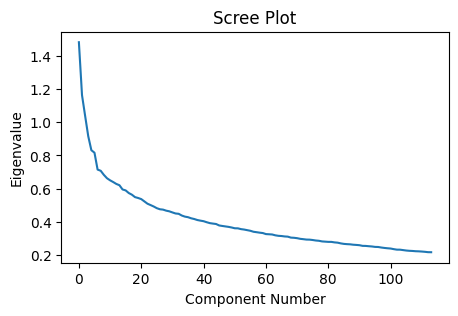

In [11]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(pca_info['Singular Values'])
ax.set_title('Scree Plot')
ax.set_xlabel('Component Number')
ax.set_ylabel('Eigenvalue')
fig.show()

## Clustering Methods

For our use purposes, clustering securities based on their percent returns gives us an insight into which companies are affected by similar factors ie. which securites are likely to be cointegrated with one another. This is critical for reducing the computation time of our strategy, as rather than computing, for example, 500 x 499 cointegration tests for a universe of size 500 stocks, if we can instead identify 20 clusters, each with 25 stocks, we reduce the number of cointegration tests nesseccary to 20 x 25^2, which is roughly 95% less computation. We will investigate three clustering algorithms - `K-Means`, `DBSCAN`, and `OPTICS`, to see which is most useful for this implementation.

### K-Means
K-Means clustering aims to partition data into $k$ clusters such that Euclidean distances within a cluster are minimized and distances between clusters are maximized. Traditionally, the elbow method is employed to determine the optimal number of $k$ clusters, where we determine the optimal number for $k$ based on the incremental reduction in distortion attained from further increasing k.


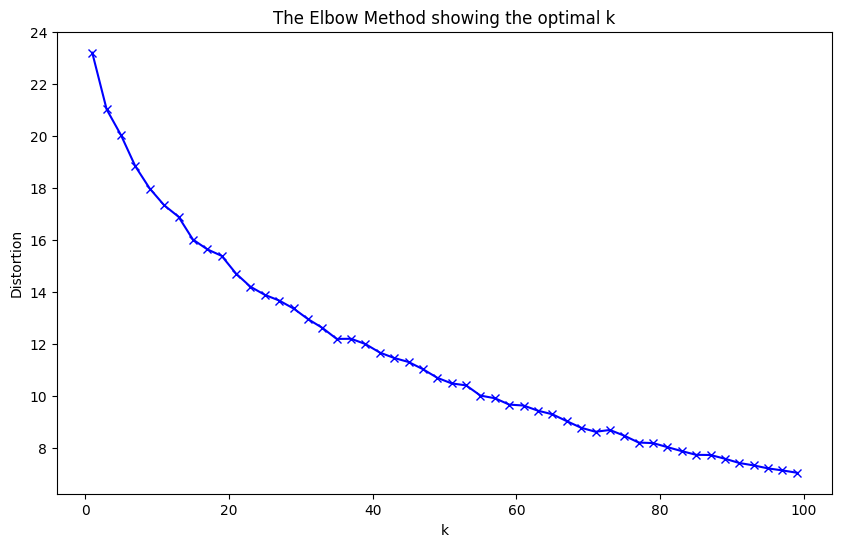

In [12]:
def find_optimal_k(transformed_data):
    distortions = []
    K = range(1, 100, 2)
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(transformed_data)
        distortions.append(kmeans.inertia_)
    plt.figure(figsize=(10,6))
    plt.plot(K, distortions, '-bx')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
find_optimal_k(transformed_data)

The K-Means algorithm is as follows:

Suppose we have $n$ input data points $x_1, \cdots, x_n$ and our predetermined value of `k = 11` industries.
1. Randomly select `k` of the $n$ data points, and let them be the `k` centroids of the `k` clusters. 
2. For each point in the data, determine the Euclidean distance from the point to the `k` centroids.
Note that the Euclidean Distance between two points $a, b \in \mathbb{R}^n$ is defined as the following: $$\text{distance}(\textbf{a}, \textbf{b}) = \sqrt{(a_1-b_1)^2 + \cdots + (a_n-b_n)^2}$$
3. Let each cluster centroid be denoted as $c_i \in C$ where $C$ is the set of all centroids, then each data point $x_i$ is assigned to the closest cluster defined by the above Euclidean distance, or $$\text{arg min}_{c_i\in C} \ \text{distance}(c_i, x)$$
4. Define the new centroid of the current cluster by taking the average of the points in the cluster. Let $S_i$ be the ith cluster. Then the new centroid is defined as $$c_i = \dfrac{1}{|S_i|}\sum_{x_i \in S_i} x_i$$ such that $S_i$ is the size of set $S_i$.
5. Continue to iterate through the input data points until the `k` centroids don't change. 

## Elbow Method vs. Industries
While the elbow method is widely used in research, we realized there were practical limitations when trying to determine when additional distortion is small enough to warrant selecting a value for $k$. Thus, we decided to instead use the number of industries (11) as our $k$.

In [13]:
def kmeans_cluster(transformed_data: array_1d) -> array_1d:
    kmeans = KMeans(n_clusters = 35)
    labels = kmeans.fit_predict(transformed_data)

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    clusters = {}
    for i in range(len(labels)):
        if labels[i] != -1:
            clusters[labels[i]] = clusters.get(labels[i], "") + str(tickers[i]) + " "
    clusters = dict(sorted(clusters.items(), key=lambda x:x[0]))

    print("Estimated number of clusters:", n_clusters)
    print("Estimated number of noise points:", n_noise)
    cluster_info = pd.DataFrame({'Cluster': clusters.keys(), 'Stocks': clusters.values()})
    cluster_info = cluster_info.set_index('Cluster')
    display(cluster_info.head(10))
    return labels

start_kmeans = time.perf_counter()
labels_kmeans = kmeans_cluster(transformed_data)

Estimated number of clusters: 35
Estimated number of noise points: 0


Stocks
Cluster                                                   
0        AAL BSX CNC COP CTRA DISH DUK ELV FDS FE GL HL...
1                                                     LLY 
2        MMM ABT ABBV ADP AAP AFL A APD ALB ARE ALGN AL...
3                                                     DIS 
4                                           JNPR LVS VRTX 
5                                                    BBWI 
6                                                     AZO 
7        AMGN CHTR CME CTSH DHR DG DOV EA FIS FTNT IR M...
8        AKAM ALK APA ANET CNP CF CMCSA CMI CVS XRAY DX...
9                                                     MTD

In [13]:
def find_cointegrated_pairs(df, labels):
    n = df.shape[1]
    keys = df.keys()
    pairsDict = {} #maps from pvalue to pair
    for i in range(n):
        for j in range(i + 1, n):
            
            # assert that both stocks are in the same cluster and not outliers
            if labels[i] != -1 and labels[j] != -1 and labels[i] == labels[j]:
                S1 = close_data[keys[i]]        
                S2 = close_data[keys[j]]
                result = coint(S1, S2)
                pvalue = result[1]
                if pvalue < 0.05 and pvalue != 0:
                    pairsDict[(keys[i], keys[j])] = pvalue

    # sort the pairs by lowest p-value
    keys, values = list(pairsDict.keys()), list(pairsDict.values())
    sorted_value_index = np.argsort(values)
    sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
    return pd.DataFrame({'Pairs': sorted_dict.keys(), "PValues": sorted_dict.values()})

In [15]:
pairs_kmeans = find_cointegrated_pairs(close_data, labels_kmeans)
end_kmeans = time.perf_counter()
print(f"Time it takes KMEANS to generate pairs in a 500 stock universe size: {end_kmeans - start_kmeans}")
pairs_kmeans.head()

Time it takes KMEANS to generate pairs in a 500 stock universe size: 229.82695979997516


Pairs   PValues
0  (ATVI, STZ)  0.000003
1   (STE, VFC)  0.000011
2  (HON, PYPL)  0.000022
3  (HON, INTU)  0.000055
4    (HPE, KR)  0.000055

0                 1                                   2
0    HD  Home Depot (The)             Home Improvement Retail
1  VRSN          Verisign  Internet Services & Infrastructure

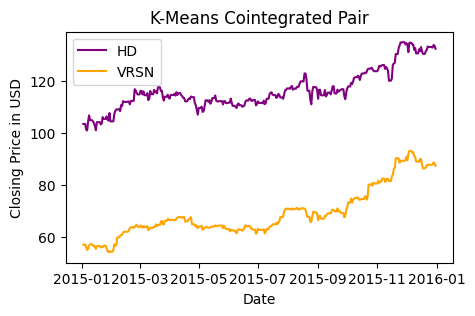

In [16]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(close_data['HD'], label = 'HD', color='purple')
ax.plot(close_data['VRSN'], label = 'VRSN', color='orange')
ax.set_title('K-Means Cointegrated Pair')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price in USD')
ax.legend()
fig.show()

HD_VRSN = [(tickers[i], names[i], industries[i]) for i in range(len(tickers)) if tickers[i]=='HD' or tickers[i]=="VRSN"]
pd.DataFrame(HD_VRSN)

### DBSCAN (Density Based Spatial Clustering of Applications)

DBSCAN is a density-based clustering algorithm, which is best suited to deal with arbitrary shapes or outliers. Given that companies are unique entities, their returns will all be affected by factors differently, so we expect there to be many outliers. DBSCAN and OPTICS are very similar. Let us define parameters and subsequent definitions to algorithmically understand both methods.

1. `eps` ($\epsilon$): the distance that specifies neighbors



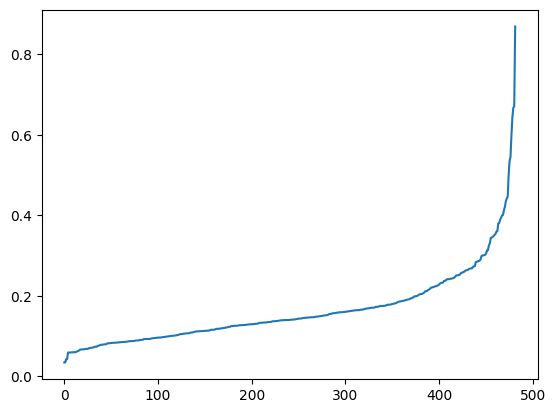

In [17]:
def find_optimal_eps(df):
    nn = NearestNeighbors(n_neighbors=2)
    nbrs = nn.fit(df)
    distances, indices = nbrs.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

find_optimal_eps(transformed_data)

- the optimal eps looks like it should be around 0.25 to 0.3, but when they're used in dbscan i only get like 1 to 2 clusters which doesn't make any sense

2. `minPts`: minimum number of data points to define a cluster. We will set this value to 2 because all we need is 2 stocks in a cluster to potentially have a cointegrated and therefore highly profitable pair.

These two parameters allow us to define the following 3 definitions.

1. **core point:** a point `x` such that there at least `minPts` number of points (inclusive of the point itself) in the closed ball $B_\epsilon(x)$.
2. **border point:** a point `x` such that it is reachable from a core point and there are less than `minPts` number of points within $B_\epsilon(x)$.
3. **outlier:** a point such that it is not a core point and it is not reachable from any core points.

The DBSCAN algorithm is as follows:

1. `minPts` and `eps` are predetermined. Suppose there exist $n$ data points $x_1, \cdots, x_n \in X$. Select a starting point $x_i$ at random.
2. Let $S$ be the set of all points in $B_\epsilon (x_i)$. If $|S| >= \ $ `minPts`, then $x_i$ is marked as a core point and cluster formation starts. Otherwise, the point is marked as noise. All other points $x_j \in B_{\epsilon}(x_i)$ become a part of the cluster. 
3. If for the other $x_j$, if there exists at least `minPts` in $B_\epsilon(x_j)$, then $x_j$ is also determined to be core points, then all $x_k \in B_\epsilon(x_j)$ are also added to the cluster and evaluated if they are core points.
4. Once that cluster is formed, choose another random point that has not been visited yet and follow the same procedure. Note that points that are marked as noise can be revisited.
5. The algorithm is done when all points classified as part of a cluster or a noise point.

In [18]:
def dbscan_cluster(transformed_data: array_1d) -> array_1d:
    
    db = DBSCAN(eps = 0.1, min_samples = 2)
    labels = db.fit_predict(transformed_data)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    clusters = {}
    for i in range(len(labels)):
        if labels[i] != -1:
            clusters[labels[i]] = clusters.get(labels[i], "") + str(tickers[i]) + " "
    clusters = dict(sorted(clusters.items(), key=lambda x:x[0]))
    
    print("Estimated number of clusters:", n_clusters)
    print("Estimated number of noise points:", n_noise)
    cluster_info = pd.DataFrame({'Cluster': clusters.keys(), 'Stocks': clusters.values()})
    cluster_info = cluster_info.set_index('Cluster')
    display(cluster_info.head())
    return labels

start_dbscan = time.perf_counter()
labels_dbscan = dbscan_cluster(transformed_data)

Estimated number of clusters: 11
Estimated number of noise points: 370


Stocks
Cluster                                                   
0        ADBE ARE LNT AXP ABC ATO BALL BDX BRK.B TECH B...
1                                           A EQT HST NEE 
2        AKAM ALK APA ANET CNP CMCSA CMI CVS XRAY DXCM ...
3        AON AMAT BA CHD DPZ DTE EIX EL ITW KEYS MOS OX...
4                                        CBOE IBM PSX WMT

In [19]:
pairs_dbscan = find_cointegrated_pairs(close_data, labels_dbscan)
end_dbscan = time.perf_counter()
print(f"Time it takes DBSCAN to generate pairs in a 500 stock universe size: {end_dbscan - start_dbscan}")
pairs_dbscan.head()

Time it takes DBSCAN to generate pairs in a 500 stock universe size: 20.760144600004423


Pairs   PValues
0  (HON, RJF)  0.000002
1  (HON, WFC)  0.000064
2   (AEP, SO)  0.000103
3  (HON, LNC)  0.000114
4   (ES, PCG)  0.000236

0              1                               2
0  HON      Honeywell        Industrial Conglomerates
1  RJF  Raymond James  Investment Banking & Brokerage

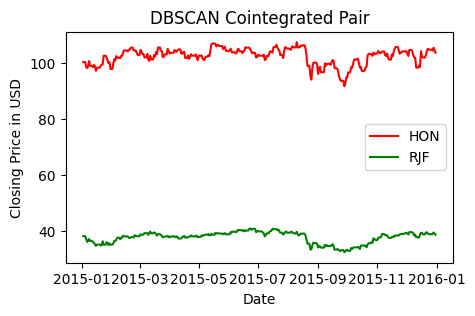

In [20]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(close_data['HON'], label = 'HON', color='red')
ax.plot(close_data['RJF'], label = 'RJF', color='green')
ax.set_title('DBSCAN Cointegrated Pair')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price in USD')
ax.legend()
fig.show()

hon_rjf = [(tickers[i], names[i], industries[i]) for i in range(len(tickers)) if tickers[i]=='HON' or tickers[i]=="RJF"]
pd.DataFrame(hon_rjf)

### OPTICS (Ordering Points to Identify Cluster Structure)

We observe firsthand that the Elbow Technique to determine optimal `eps` is unreliable and cumbersome. Such a small difference in the value of `eps` can drastically transform final results. This required level of precision for `eps` limits DBSCAN predominantly to the detection of clusters of similar density. OPTICS solves this issue 

In [21]:
def optics_cluster(transformed_data: array_1d) -> array_1d:
    optics = OPTICS(min_samples = 2)
    labels = optics.fit_predict(transformed_data)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    clusters = {}
    for i in range(len(labels)):
        if labels[i] != -1:
            clusters[labels[i]] = clusters.get(labels[i], "") + str(tickers[i]) + " "
    clusters = dict(sorted(clusters.items(), key=lambda x:x[0]))
    
    print("Estimated number of clusters:", n_clusters)
    print("Estimated number of noise points:", n_noise)
    cluster_info = pd.DataFrame({'Cluster': clusters.keys(), 'Stocks': clusters.values()})
    cluster_info = cluster_info.set_index('Cluster')
    display(cluster_info.head())
    return labels
    
start_optics = time.perf_counter()
labels_optics = optics_cluster(transformed_data)

Estimated number of clusters: 40
Estimated number of noise points: 375


Stocks
Cluster                                
0                         ABC TECH LYV 
1                              BMY STT 
2                             LNT BIIB 
3                              ARE EXR 
4        BKNG FLT HUM OMC SBNY TER UAL

In [22]:
pairs_optics = find_cointegrated_pairs(close_data, labels_optics)
end_optics = time.perf_counter()
print(f"Time it takes OPTICS to generate pairs in a 500 stock universe size: {end_optics - start_optics}")
pairs_optics.head()

Time it takes OPTICS to generate pairs in a 500 stock universe size: 5.964553400001023


Pairs   PValues
0   (AEE, XEL)  0.000607
1   (AEE, CMS)  0.000917
2   (PNW, WEC)  0.006713
3   (TFC, WFC)  0.010048
4  (ICE, NDAQ)  0.013386

0            1                2
0  AEE       Ameren  Multi-Utilities
1  XEL  Xcel Energy  Multi-Utilities

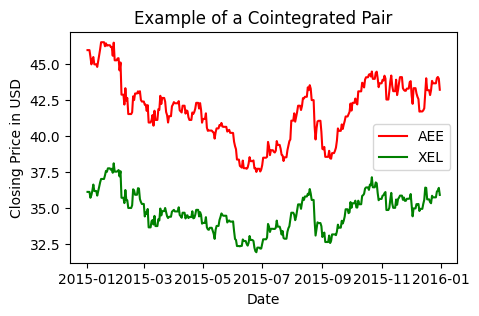

In [23]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(close_data['AEE'], label = 'AEE', color='red')
ax.plot(close_data['XEL'], label = 'XEL', color='green')
ax.set_title('Example of a Cointegrated Pair')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price in USD')
ax.legend()
fig.show()

aee_xel = [(tickers[i], names[i], industries[i]) for i in range(len(tickers)) if tickers[i]=='AEE' or tickers[i]=="XEL"]
pd.DataFrame(aee_xel)

## Testing KMeans vs. DBSCAN vs. OPTICS in Alphas

Done!: 100%|██████████| 3/3 [1:06:13<00:00, 1324.43s/it]   


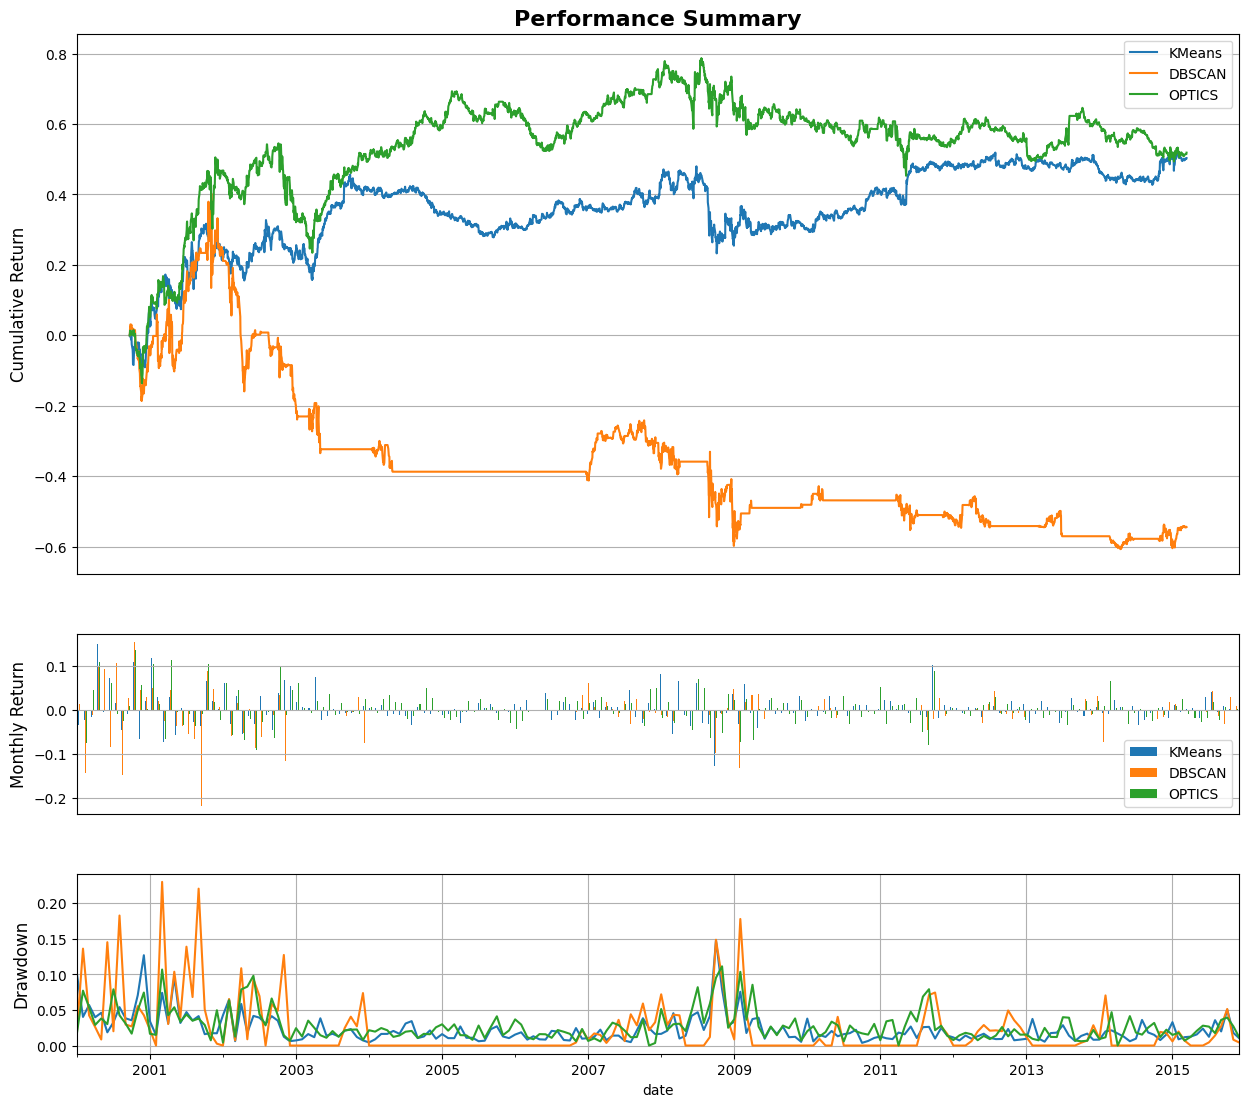

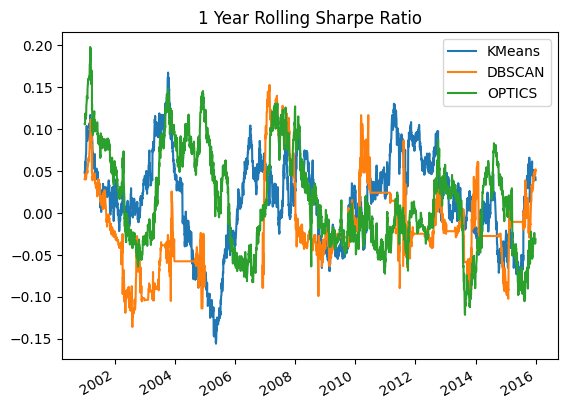

KMeans


C:\Users\James Zhang\AppData\Local\Temp\ipykernel_17092\3111551255.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  ICD.display(table)


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.169274  0.771775  1.325042  0.126996  0.206622    7.277778   
2001     0.077275  0.472291  0.662713  0.156499  0.189148    7.028226   
2002     0.099258  0.690279  1.064682  0.160360  0.192927    7.507937   
2003     0.057132  0.708964  1.196742  0.065929  0.184446    7.511905   
2004    -0.068510 -1.229474 -1.879321  0.095697  0.132301    8.440476   
2005    -0.032155 -0.568140 -0.813495  0.058899  0.191877    7.448413   
2006     0.059086  0.965711  1.556480  0.039907  0.201162    8.035857   
2007     0.028832  0.433407  0.683268  0.053777  0.172098    7.665339   
2008    -0.111844 -0.687439 -0.974287  0.224595  0.183347    7.616601   
2009     0.062959  0.439782  0.793014  0.088561  0.200951    7.265873   
2010     0.016349  0.268890  0.386208  0.047368  0.195068    7.746032   
2011     0.116805  1.392959  2.599334  0.049979  0.183196    7.392857   
2012     0.024189  0.441061  0.740090  0.025290  0.180268    7.940000   
2013    -0.015767 -0.286858 -0.433483  0.051788  0.183094    7.829365   
2014    -0.028863 -0.523020 -0.663293  0.076819  0.174572    8.369048   
2015     0.049143  0.625889  0.808997  0.050405  0.201455    7.333333   
Overall  0.503163  0.288725  0.408193  0.224595  0.252698    7.650932   

         short count  
year                  
2000        6.277778  
2001        6.028226  
2002        6.507937  
2003        6.511905  
2004        7.440476  
2005        6.448413  
2006        7.035857  
2007        6.665339  
2008        6.616601  
2009        6.265873  
2010        6.746032  
2011        6.392857  
2012        6.940000  
2013        6.829365  
2014        7.369048  
2015        6.333333  
Overall     6.650932


DBSCAN


C:\Users\James Zhang\AppData\Local\Temp\ipykernel_17092\3111551255.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  ICD.display(table)


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.183102  0.639925  0.751485  0.197407  0.171758    4.238095   
2001    -0.175253 -0.395356 -0.519308  0.451073  0.145852    2.971774   
2002    -0.331415 -1.647128 -1.980194  0.304607  0.030172    1.519841   
2003    -0.063867 -0.916326 -1.175804  0.085575  0.008511    1.289683   
2004     0.000000       NaN       NaN  0.000000  0.000000    1.000000   
2005     0.000000       NaN       NaN  0.000000  0.000000    1.000000   
2006     0.030619  0.905506  1.609432  0.024977  0.000000    1.083665   
2007     0.051237  0.480597  0.715031  0.090740  0.138177    2.374502   
2008    -0.165737 -0.678687 -0.974979  0.228617  0.054721    2.197628   
2009    -0.018833 -0.099162 -0.133042  0.177941  0.038627    1.242063   
2010     0.021371  0.384089  0.540455  0.040384  0.017021    1.142857   
2011    -0.041715 -0.393825 -0.431639  0.099981  0.066104    1.722222   
2012    -0.015329 -0.175854 -0.238336  0.084011  0.052521    1.572000   
2013    -0.005612 -0.123979 -0.163720  0.028553  0.025751    1.242063   
2014    -0.074949 -1.310583 -1.363143  0.104185  0.049107    2.178571   
2015     0.061882  0.803973  1.063004  0.066133  0.124573    2.773810   
Overall -0.544498 -0.198957 -0.262766  0.680660  0.088050    1.845963   

         short count  
year                  
2000        3.238095  
2001        1.971774  
2002        0.519841  
2003        0.289683  
2004        0.000000  
2005        0.000000  
2006        0.083665  
2007        1.374502  
2008        1.197628  
2009        0.242063  
2010        0.142857  
2011        0.722222  
2012        0.572000  
2013        0.242063  
2014        1.178571  
2015        1.773810  
Overall     0.845963


OPTICS


C:\Users\James Zhang\AppData\Local\Temp\ipykernel_17092\3111551255.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  ICD.display(table)


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.309458  1.686151  3.128807  0.141192  0.207134    6.869048   
2001     0.171181  0.836600  1.152197  0.156644  0.191352    6.919355   
2002    -0.089600 -0.479328 -0.719799  0.276506  0.138234    4.968254   
2003     0.137751  1.397952  2.342513  0.037434  0.197477    4.448413   
2004     0.144092  1.854379  3.180775  0.053674  0.181805    5.003968   
2005    -0.062919 -0.792113 -1.103850  0.079965  0.168584    3.579365   
2006    -0.001719 -0.021737 -0.027877  0.079167  0.185961    5.685259   
2007     0.147951  2.019832  3.152348  0.042394  0.152864    3.513944   
2008    -0.069985 -0.338160 -0.547443  0.182712  0.136333    5.434783   
2009    -0.053658 -0.357139 -0.448410  0.158835  0.192565    5.571429   
2010    -0.074692 -0.976362 -1.515890  0.101802  0.183774    5.309524   
2011    -0.001047 -0.007161 -0.010062  0.157510  0.106222    2.646825   
2012     0.047059  0.773217  1.198947  0.037374  0.193773    6.356000   
2013    -0.076638 -1.276637 -1.581510  0.097154  0.151104    7.253968   
2014     0.025601  0.296686  0.418481  0.106210  0.121152    4.611111   
2015    -0.034104 -0.497891 -0.713980  0.091245  0.179959    6.753968   
Overall  0.518730  0.255711  0.354252  0.305650  0.235531    5.306087   

         short count  
year                  
2000        5.869048  
2001        5.919355  
2002        3.968254  
2003        3.448413  
2004        4.003968  
2005        2.579365  
2006        4.685259  
2007        2.513944  
2008        4.434783  
2009        4.571429  
2010        4.309524  
2011        1.646825  
2012        5.356000  
2013        6.253968  
2014        3.611111  
2015        5.753968  
Overall     4.306087

In [24]:
from sif.pairstrading.alphas import KMeans_Alpha, DBSCAN_Alpha, OPTICS_Alpha

alphas = [KMeans_Alpha(90, 10, 0.5), DBSCAN_Alpha(90, 10, 0.5), OPTICS_Alpha(90, 10, 0.5)]
returns, holdings = backtester_15y.backtest(alphas, processes=6)
metrics.summary_plot(returns, source=['KMeans', 'DBSCAN', 'OPTICS'])

rolling_sharpe = functools.partial(metrics.rolling_metric, func=metrics.sharpe_ratio, window=252)
returns.apply(rolling_sharpe).plot()
plt.title('1 Year Rolling Sharpe Ratio')
plt.show()

perf_tables = apply_metric_func(metrics.generate_performance_table, ('daily_returns', 'holdings'))(returns, holdings)
for alpha, table in zip(alphas, perf_tables):
    print(f"{alpha.name}")
    ICD.display(table)
    print()

## Clustering - Conclusion

Of the three methods, we select OPTICS to use in our final alpha moving forward. Although the OPTICS and kmeans clustering methods give similar performance, OPTICS runs much quicker, and kmeans is further limited by the need to manually select k. 

Thus, we will continue to build on our alpha using OPTICS as our clustering method for the rest of the notebook.

**Critically, notice that the performance of these alphas is similar/better than the original brute force lowest pvalue alpha. This is extremely important as it means we are losing minimal value by using clustering to reduce the number of pairs of securities we check cointegration between, while gaining massive computational advantage.**

## Time Complexity Analysis - Clustering vs. Original

The objective of principal component analysis and clustering methods is to identify cointegrated pairs faster and more efficiently. Thus, let us conduct a time complexity analysis of a bare bones pairs trading strategy versus an enhanced strategy when both are tested in a 500 stock universe. We also want to create a short 6 month backtester for the sole purpose of conducting this time complexity comparison.

In [25]:
# *** FOP TIME COMPLEXITY ANALYSIS *** #
start_date_6m = datetime.datetime(2005, 1, 1)
end_date_6m = datetime.datetime(2005, 6, 30)
# backtester_6m = fb.FullMultipleBacktester(
#     start_date_6m,
#     end_date_6m,
#     'M',
#     273,
#     universe_size = 500, 
#     factors=['close', 'sector']
# )

# backtester_6m.save_local('pairs_6m.npy')
backtester_6m = fb.FullMultipleBacktester.from_local('pairs_6m.npy')

In [36]:
from pairs.alphas import Brute_Force, Testing2

# run the brute force alpha and time it
alphas = [Brute_Force(90, 10, 3.5)]
start_random = time.perf_counter()
returns, holdings = backtester_6m.backtest(alphas, processes=None)
end_random = time.perf_counter()


In [35]:
# run the enhanced alpha and time it
alphas = [Testing2(90, 10, 2.25, 1.75, 3.5)]
start_final = time.perf_counter()
returns2, holdings2 = backtester_6m.backtest(alphas, processes=None)
end_final = time.perf_counter()

print(f"Time for the Random Alpha: {end_random - start_random} seconds")
print(f"Time for the Enhanced Alpha: {end_final - start_final} seconds")

Testing2: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.94s/it]

Time for the Random Alpha: 2433.187252399999 seconds
Time for the Enhanced Alpha: 6.951922000000195 seconds


In [ ]:
# run the brute force alpha and time it
alphas = [Brute_Force(90, 10, 3.5)]
start_random = time.perf_counter()
returns, holdings = backtester_6m.backtest(alphas, processes=None)
end_random = time.perf_counter()

In [27]:
# run the enhanced alpha and time it
alphas = [Testing2(90, 10, 2.25, 1.75, 3.5)]
start_final = time.perf_counter()
returns2, holdings2 = backtester_6m.backtest(alphas, processes=None)
end_final = time.perf_counter()

print(f"Time for the Random Alpha: {end_random - start_random} seconds")
print(f"Time for the Enhanced Alpha: {end_final - start_final} seconds")

Testing2: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.51s/it]

Time for the Random Alpha: 2495.6983089000023 seconds
Time for the Enhanced Alpha: 6.517251000001124 seconds


# Pairs Trading Parameters

There are many parameters that we can tune for pairs trading to build the optimal strategy. In this portion of the notebook, we will explore them.

### Thresholds

We define opening and closing of trade thresholds for our trades by cutoff values of the z-score of the spread between the price timeseries of the two securities. Z-score is defined as $$z = \dfrac{x-\mu}{\sigma}$$ where $x$ is some value, $\mu$ is the mean, and $\sigma$ is the standard deviation, and this value represents the number of standard deviations away from the mean our current value is.

In [7]:
def zscore(series: array_1d) -> array_1d:
    return (series - series.mean()) / np.std(series)

In [26]:
pairsDict = dict(np.array(pairs_optics))
pairsDict

# sort the pairs by lowest p-value
keys, values = list(pairsDict.keys()), list(pairsDict.values())
sorted_value_index = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}

# a stock should only be included once in our holdings to prevent mishaps
new_dict, seen = {}, set()
for (i, j) in sorted_dict:
    if i not in seen and j not in seen:
        new_dict[(i, j)] = sorted_dict[(i,j)]
        seen.add(i)

new_dict

{('AEE', 'XEL'): 0.0006074891966837364,
 ('PNW', 'WEC'): 0.006712663328868038,
 ('TFC', 'WFC'): 0.010048276260052667,
 ('ICE', 'NDAQ'): 0.01338565196103155,
 ('AMT', 'CCI'): 0.01917978540057863,
 ('KO', 'PEP'): 0.027679852301702584,
 ('CMS', 'ES'): 0.03140211257431001,
 ('AON', 'MMC'): 0.03678558565664893,
 ('C', 'HBAN'): 0.037287845225351904,
 ('CI', 'UNH'): 0.04340813007876985}

### Open Position Criteria

A trade will be initialized (ie. we take a long position for the underperforming security and a short position on the overperforming security) when the absolute value of the zscore of the spread is greater than our open threshold, currently 1.0.
### Close Position Criteria

The trade will be closed when the asbolute value of the zscore of the spread becomes less than our close (take profit) threshold, which is currently 0.5. If this threshold is reached on an open position, it means the difference between close prices have revered back toward their mean and a profit should be made.

### Stop Loss Criteria

In the circumstance where two securities seem to continue to diverge beyond what we consider reasonable, we propose a mechanism for cutting our losses by exiting the trade. If the absolute of the zscore of the spread ever becomes greater than our stop loss threshold, we reevaluate the cointegration levels again using the Engel Granger test. If the resulting pvalue is greater than 0.05 (no longer cointegrated), we choose to suspect that the pair is no longer cointegrated, and we will exit the trade and take our losses before the securities further diverge and result in even greater losses.

In [16]:
WINDOW, OPEN, CLOSE = 90, 2.1, 1.9
factors = ['Zscore', 'Close Prices', 'Spread']
df = {factor : pd.DataFrame(np.zeros((180-WINDOW, len(new_dict)))) for factor in factors}
pairs = [pair for pair in new_dict]

for factor in df:
    df[factor] = df[factor].rename_axis("Day")
    df[factor] = df[factor].set_axis(pairs, axis="columns")
    new_axis = [i for i in range(WINDOW, 180)]
    df[factor] = df[factor].set_axis(new_axis, axis="rows")
    df[factor] = df[factor].rename_axis(f"{factor} of Pairs", axis="columns")
    display(df[factor])

Zscore of Pairs  (AEP, SO)  (ES, PCG)  (AEE, XEL)  (PCG, SO)  (PNW, WEC)  \
90                     0.0        0.0         0.0        0.0         0.0   
91                     0.0        0.0         0.0        0.0         0.0   
92                     0.0        0.0         0.0        0.0         0.0   
93                     0.0        0.0         0.0        0.0         0.0   
94                     0.0        0.0         0.0        0.0         0.0   
..                     ...        ...         ...        ...         ...   
175                    0.0        0.0         0.0        0.0         0.0   
176                    0.0        0.0         0.0        0.0         0.0   
177                    0.0        0.0         0.0        0.0         0.0   
178                    0.0        0.0         0.0        0.0         0.0   
179                    0.0        0.0         0.0        0.0         0.0   

Zscore of Pairs  (TFC, WFC)  (ICE, NDAQ)  (AMT, CCI)  (CNP, DUK)  (KO, PEP)  \
90                      0.0          0.0         0.0         0.0        0.0   
91                      0.0          0.0         0.0         0.0        0.0   
92                      0.0          0.0         0.0         0.0        0.0   
93                      0.0          0.0         0.0         0.0        0.0   
94                      0.0          0.0         0.0         0.0        0.0   
..                      ...          ...         ...         ...        ...   
175                     0.0          0.0         0.0         0.0        0.0   
176                     0.0          0.0         0.0         0.0        0.0   
177                     0.0          0.0         0.0         0.0        0.0   
178                     0.0          0.0         0.0         0.0        0.0   
179                     0.0          0.0         0.0         0.0        0.0   

Zscore of Pairs  (ETR, FE)  (AON, MMC)  (C, HBAN)  (DUK, FE)  (CI, UNH)  \
90                     0.0         0.0        0.0        0.0        0.0   
91                     0.0         0.0        0.0        0.0        0.0   
92                     0.0         0.0        0.0        0.0        0.0   
93                     0.0         0.0        0.0        0.0        0.0   
94                     0.0         0.0        0.0        0.0        0.0   
..                     ...         ...        ...        ...        ...   
175                    0.0         0.0        0.0        0.0        0.0   
176                    0.0         0.0        0.0        0.0        0.0   
177                    0.0         0.0        0.0        0.0        0.0   
178                    0.0         0.0        0.0        0.0        0.0   
179                    0.0         0.0        0.0        0.0        0.0   

Zscore of Pairs  (CMS, WEC)  
90                      0.0  
91                      0.0  
92                      0.0  
93                      0.0  
94                      0.0  
..                      ...  
175                     0.0  
176                     0.0  
177                     0.0  
178                     0.0  
179                     0.0  

[90 rows x 16 columns]

Close Prices of Pairs  (AEP, SO)  (ES, PCG)  (AEE, XEL)  (PCG, SO)  \
90                           0.0        0.0         0.0        0.0   
91                           0.0        0.0         0.0        0.0   
92                           0.0        0.0         0.0        0.0   
93                           0.0        0.0         0.0        0.0   
94                           0.0        0.0         0.0        0.0   
..                           ...        ...         ...        ...   
175                          0.0        0.0         0.0        0.0   
176                          0.0        0.0         0.0        0.0   
177                          0.0        0.0         0.0        0.0   
178                          0.0        0.0         0.0        0.0   
179                          0.0        0.0         0.0        0.0   

Close Prices of Pairs  (PNW, WEC)  (TFC, WFC)  (ICE, NDAQ)  (AMT, CCI)  \
90                            0.0         0.0          0.0         0.0   
91                            0.0         0.0          0.0         0.0   
92                            0.0         0.0          0.0         0.0   
93                            0.0         0.0          0.0         0.0   
94                            0.0         0.0          0.0         0.0   
..                            ...         ...          ...         ...   
175                           0.0         0.0          0.0         0.0   
176                           0.0         0.0          0.0         0.0   
177                           0.0         0.0          0.0         0.0   
178                           0.0         0.0          0.0         0.0   
179                           0.0         0.0          0.0         0.0   

Close Prices of Pairs  (CNP, DUK)  (KO, PEP)  (ETR, FE)  (AON, MMC)  \
90                            0.0        0.0        0.0         0.0   
91                            0.0        0.0        0.0         0.0   
92                            0.0        0.0        0.0         0.0   
93                            0.0        0.0        0.0         0.0   
94                            0.0        0.0        0.0         0.0   
..                            ...        ...        ...         ...   
175                           0.0        0.0        0.0         0.0   
176                           0.0        0.0        0.0         0.0   
177                           0.0        0.0        0.0         0.0   
178                           0.0        0.0        0.0         0.0   
179                           0.0        0.0        0.0         0.0   

Close Prices of Pairs  (C, HBAN)  (DUK, FE)  (CI, UNH)  (CMS, WEC)  
90                           0.0        0.0        0.0         0.0  
91                           0.0        0.0        0.0         0.0  
92                           0.0        0.0        0.0         0.0  
93                           0.0        0.0        0.0         0.0  
94                           0.0        0.0        0.0         0.0  
..                           ...        ...        ...         ...  
175                          0.0        0.0        0.0         0.0  
176                          0.0        0.0        0.0         0.0  
177                          0.0        0.0        0.0         0.0  
178                          0.0        0.0        0.0         0.0  
179                          0.0        0.0        0.0         0.0  

[90 rows x 16 columns]

Spread of Pairs  (AEP, SO)  (ES, PCG)  (AEE, XEL)  (PCG, SO)  (PNW, WEC)  \
90                     0.0        0.0         0.0        0.0         0.0   
91                     0.0        0.0         0.0        0.0         0.0   
92                     0.0        0.0         0.0        0.0         0.0   
93                     0.0        0.0         0.0        0.0         0.0   
94                     0.0        0.0         0.0        0.0         0.0   
..                     ...        ...         ...        ...         ...   
175                    0.0        0.0         0.0        0.0         0.0   
176                    0.0        0.0         0.0        0.0         0.0   
177                    0.0        0.0         0.0        0.0         0.0   
178                    0.0        0.0         0.0        0.0         0.0   
179                    0.0        0.0         0.0        0.0         0.0   

Spread of Pairs  (TFC, WFC)  (ICE, NDAQ)  (AMT, CCI)  (CNP, DUK)  (KO, PEP)  \
90                      0.0          0.0         0.0         0.0        0.0   
91                      0.0          0.0         0.0         0.0        0.0   
92                      0.0          0.0         0.0         0.0        0.0   
93                      0.0          0.0         0.0         0.0        0.0   
94                      0.0          0.0         0.0         0.0        0.0   
..                      ...          ...         ...         ...        ...   
175                     0.0          0.0         0.0         0.0        0.0   
176                     0.0          0.0         0.0         0.0        0.0   
177                     0.0          0.0         0.0         0.0        0.0   
178                     0.0          0.0         0.0         0.0        0.0   
179                     0.0          0.0         0.0         0.0        0.0   

Spread of Pairs  (ETR, FE)  (AON, MMC)  (C, HBAN)  (DUK, FE)  (CI, UNH)  \
90                     0.0         0.0        0.0        0.0        0.0   
91                     0.0         0.0        0.0        0.0        0.0   
92                     0.0         0.0        0.0        0.0        0.0   
93                     0.0         0.0        0.0        0.0        0.0   
94                     0.0         0.0        0.0        0.0        0.0   
..                     ...         ...        ...        ...        ...   
175                    0.0         0.0        0.0        0.0        0.0   
176                    0.0         0.0        0.0        0.0        0.0   
177                    0.0         0.0        0.0        0.0        0.0   
178                    0.0         0.0        0.0        0.0        0.0   
179                    0.0         0.0        0.0        0.0        0.0   

Spread of Pairs  (CMS, WEC)  
90                      0.0  
91                      0.0  
92                      0.0  
93                      0.0  
94                      0.0  
..                      ...  
175                     0.0  
176                     0.0  
177                     0.0  
178                     0.0  
179                     0.0  

[90 rows x 16 columns]

In [28]:
# 3/4 a year; we need to wait the first 1/4 s.t. we can calculate z_score
for day in range(WINDOW, 180):
    for p in new_dict:

        FIRST = (close_data[p[0]]).iloc[day-WINDOW:day]
        SECOND = (close_data[p[1]]).iloc[day-WINDOW:day]
        # caclulate data
        close_price = f"({round(close_data[p[0]][day], 2)} , {round(close_data[p[1]][day], 2)})"
        spread = FIRST - SECOND
        z_score = zscore(spread).tail(1).values[0]
        diff = close_data[p[0]][day] - close_data[p[1]][day]

        # add to dataframes
        for factor in factors:
            if factor == "Zscore":
                if z_score >= OPEN:
                    # update current trade status
                    df[factor][p][day] = f"OPEN {round(z_score, 2)}"

                # exit the trade; dont increment anything
                elif abs(z_score) <= CLOSE:
                    df[factor][p][day] = f"CLOSED {round(z_score, 2)}"

                # enter the trade; long the FIRST, short SECOND
                elif z_score <= -OPEN:
                    df[factor][p][day] = f"OPEN {round(z_score, 2)}"
            
            elif factor == "Close Prices":
                df[factor][p][day] = close_price
            elif factor == "Spread":
                df[factor][p][day] = round(diff, 2)

In [29]:
for factor in factors:
    print(df[factor].to_markdown())
    print()

|     | ('AEE', 'XEL')   | ('PNW', 'WEC')   | ('TFC', 'WFC')   | ('ICE', 'NDAQ')   | ('AMT', 'CCI')   | ('KO', 'PEP')   | ('CMS', 'ES')   | ('AON', 'MMC')   | ('C', 'HBAN')   | ('CI', 'UNH')   |
|----:|:-----------------|:-----------------|:-----------------|:------------------|:-----------------|:----------------|:----------------|:-----------------|:----------------|:----------------|
|  90 | CLOSED -0.3      | CLOSED -0.34     | CLOSED 1.81      | CLOSED 0.37       | CLOSED 0.21      | CLOSED 0.36     | CLOSED 1.28     | CLOSED -0.14     | CLOSED 0.15     | OPEN 2.21       |
|  91 | CLOSED -0.25     | CLOSED -0.6      | CLOSED 1.71      | CLOSED 0.16       | CLOSED 0.21      | CLOSED -0.03    | CLOSED 1.39     | CLOSED -0.14     | CLOSED 0.28     | OPEN 2.18       |
|  92 | CLOSED -0.23     | CLOSED -0.58     | CLOSED 1.67      | CLOSED 0.15       | CLOSED 0.25      | CLOSED -0.01    | CLOSED 1.36     | CLOSED -0.16     | CLOSED 0.31     | OPEN 2.1        |
|  93 | CLOSED -0.21     

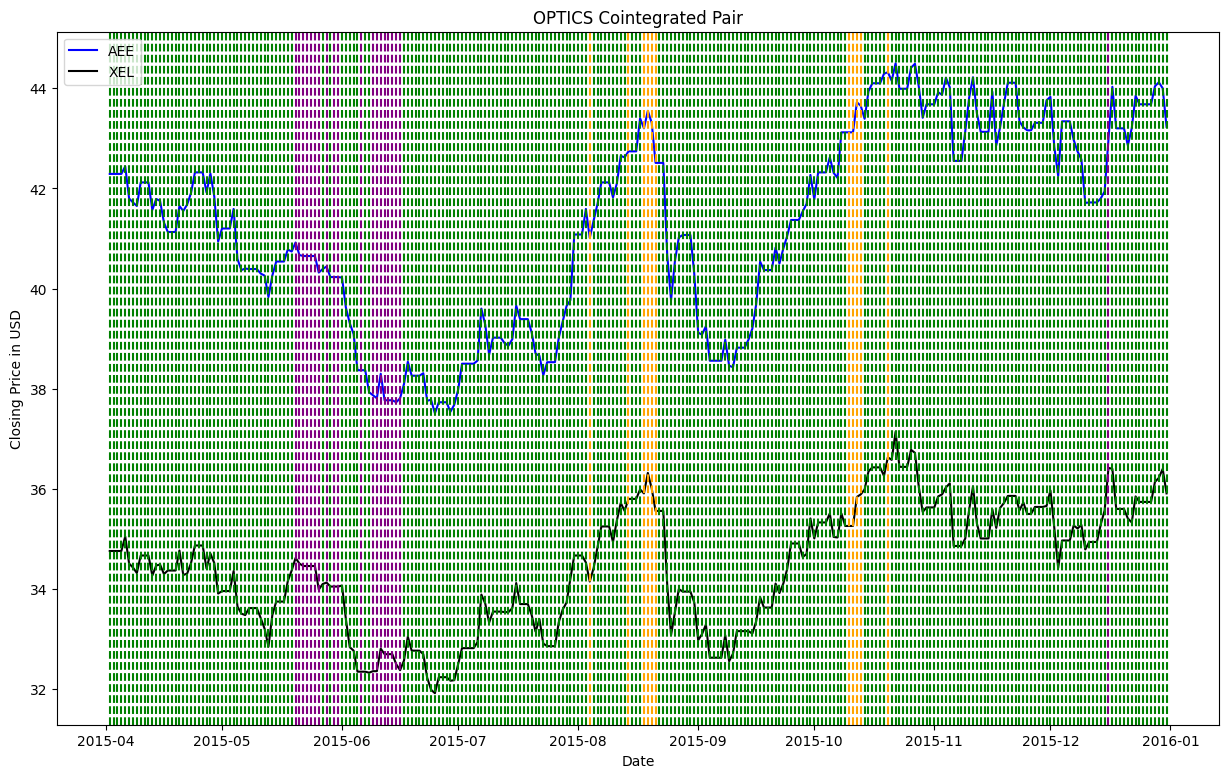

In [30]:
# Define zscore thresholds
OPEN, CLOSE, STOP, WINDOW = 2.0, 2.0, 3.5, 90

aee = pd.DataFrame(close_data["AEE"])
xel = pd.DataFrame(close_data["XEL"])
aee_2 = aee[WINDOW:]
xel_2 = xel[WINDOW:]

fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(aee_2, label = 'AEE', color='blue')
ax.plot(xel_2, label = 'XEL', color='black')

for day in range(WINDOW, len(aee)):
    aee_2 = aee.iloc[day-WINDOW:day]
    xel_2 = xel.iloc[day-WINDOW:day]
    spread = aee_2['AEE'] - xel_2['XEL']
    z_score = zscore(spread).tail(1).values[0]
    if z_score > OPEN and z_score < STOP:
        plt.axvline(x=(aee.reset_index())['date'][day], color='orange', linestyle='--')
    elif abs(z_score) < CLOSE:
        plt.axvline(x=(aee.reset_index())['date'][day], color='green', linestyle='--')
    elif abs(z_score) > STOP:
        plt.axvline(x=(aee.reset_index())['date'][day], color='red', linestyle='--')
    elif z_score < -OPEN and z_score > -STOP:
        plt.axvline(x=(aee.reset_index())['date'][day], color='purple', linestyle='--')

ax.set_title('OPTICS Cointegrated Pair')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price in USD')
ax.legend()
fig.show()

## Information about the OPTICS Pairs
- number of pairs trades opened
- average length of trade opened
- generate a graph of the zscore distributions

In [31]:
OPEN, CLOSE, STOP, WINDOW = 1.0, 0.5, 3.5, 90

# *** NUMBER OF PAIR TRADES OPENED *** #
# dict that maps from a pair to a boolean indicating if the pair is active
pair_to_status = {pair : [0, False] for pair in new_dict}

# *** AVERAGE CHANGE IN ZSCORE FOR EACH PAIR *** #
# dict that maps from a pair to changes in zscore
# first index represents postiive shifts, second is negative shifts, third is overall
pair_to_delta_zscore = {pair : [0, 0, 0] for pair in new_dict}
pos, neg = 0, 0

# *** MAX, MIN CHANGE IN ZSCORE FOR EACH PAIR *** #
# dict that maps from a pair to changes in zscore
# first index represents postiive shifts, second is negative shifts, third is overall
pair_to_minmax_zscore = {pair : [0, 0] for pair in new_dict}

# *** NUMBER OF PAIR TRADES CLOSED *** #
# dict that maps from a pair to a boolean indicating if the pair is active
pair_to_close = {pair : 0 for pair in new_dict}

# *** TOTAL LENGTH OF EACH TRADE OPENED *** #
# dict that maps from pair to total time opened
# to get average, will divide by number of trades after
pair_to_total_time = {pair : 0 for pair in new_dict}

# *** AVERAGE LENGTH OF EACH TRADE OPENED *** #
# to get average, will divide by number of trades after
pair_to_average_time = {pair : 0 for pair in new_dict}

# *** ZSCORE FREQUENCY *** #
# dict that maps from a zscore to the number of occurrences
zscore_freq = {}

# zscore jump frequency

In [32]:
# 3/4 a year; we need to wait the first 1/4 s.t. we can calculate z_score
for day in range(WINDOW, len(close_data)):
    for p in new_dict:
        # FIRST and SECOND are indices of the stocks

        FIRST = (close_data[p[0]]).iloc[day-WINDOW:day]
        SECOND = (close_data[p[1]]).iloc[day-WINDOW:day]
        spread = FIRST - SECOND
        
        #zscore tells us how far from away from the mean a close_data point is
        z_score = zscore(spread).tail(1).values[0]
        if z_score > 0:
            pair_to_delta_zscore[p][0] += z_score
            pos += 1
            pair_to_minmax_zscore[p][0] = max(z_score, pair_to_minmax_zscore[p][0])
        else:
            pair_to_delta_zscore[p][1] += z_score
            neg += 1
            pair_to_minmax_zscore[p][1] = min(z_score, pair_to_minmax_zscore[p][1])
        pair_to_delta_zscore[p][2] += z_score
        

        tempZ = round(z_score, 1) # round z_score to the nearest tenth
        zscore_freq[tempZ] = zscore_freq.get(tempZ, 0) + 1

        # enter the trade; short FIRST, long SECOND
        if z_score >= OPEN:
            # update current trade status
            if not pair_to_status[p][1]:
                pair_to_status[p][0] += 1 # increment number of trades
                pair_to_status[p][1] = True
            pair_to_total_time[p] += 1

        # exit the trade; dont increment anything
        elif abs(z_score) <= CLOSE:
            if pair_to_status[p][1]:
                pair_to_status[p][1] = False
                pair_to_close[p] += 1

        # enter the trade; long the FIRST, short SECOND
        elif z_score <= -OPEN:
            if not pair_to_status[p][1]:
                pair_to_status[p][0] += 1 # increment number of trades
                pair_to_status[p][1] = True
            pair_to_total_time[p] += 1

In [33]:
for pair in pair_to_average_time:
    # average time per trade = total time opened / number of trades
    pair_to_average_time[pair] = pair_to_total_time[pair] / pair_to_status[pair][0]
    pair_to_delta_zscore[pair][0] = round(pair_to_delta_zscore[pair][0]/pos, 4)
    pair_to_delta_zscore[pair][1] = round(pair_to_delta_zscore[pair][1]/neg, 4)
    pair_to_delta_zscore[pair][2] = round(pair_to_delta_zscore[pair][2]/(pos+neg), 4)

In [34]:
pairs_info = pd.DataFrame({'Pair': pair_to_status.keys(),
                           'Pvalues': new_dict.values(), 
                           'Number of Trades Opened': pair_to_status.values(),
                           'Number of Trades Closed': pair_to_close.values(),
                           'Total Time Open': pair_to_total_time.values(), 
                           'Average Time Open': pair_to_average_time.values(), 
                           'Average Changes in Zscore': pair_to_delta_zscore.values(), 
                           'Max Min Changes in Zscore': pair_to_minmax_zscore.values()})
display(pairs_info)

Pair   Pvalues Number of Trades Opened  Number of Trades Closed  \
0   (AEE, XEL)  0.000607              [8, False]                        8   
1   (PNW, WEC)  0.006713             [11, False]                       11   
2   (TFC, WFC)  0.010048             [10, False]                       10   
3  (ICE, NDAQ)  0.013386             [11, False]                       11   
4   (AMT, CCI)  0.019180               [8, True]                        7   
5    (KO, PEP)  0.027680             [12, False]                       12   
6    (CMS, ES)  0.031402             [12, False]                       12   
7   (AON, MMC)  0.036786               [8, True]                        7   
8    (C, HBAN)  0.037288              [8, False]                        8   
9    (CI, UNH)  0.043408               [5, True]                        4   

   Total Time Open  Average Time Open   Average Changes in Zscore  \
0              153          19.125000   [0.1104, -0.1183, 0.0027]   
1              116          10.545455  [0.0737, -0.1248, -0.0198]   
2              117          11.700000  [0.0723, -0.1069, -0.0121]   
3              105           9.545455   [0.1116, -0.0698, 0.0261]   
4              107          13.375000   [0.1092, -0.0808, 0.0197]   
5               96           8.000000  [0.0702, -0.1088, -0.0141]   
6              135          11.250000    [0.1243, -0.077, 0.0294]   
7              131          16.375000  [0.0951, -0.1247, -0.0084]   
8              142          17.750000   [0.1434, -0.0801, 0.0381]   
9              161          32.200000    [0.1769, -0.0775, 0.057]   

                   Max Min Changes in Zscore  
0   [2.6199746024438033, -2.940468762540469]  
1    [2.456090906426008, -4.148591408595112]  
2   [2.5084880654723043, -2.459876269982127]  
3    [3.86429936699181, -1.7148936705082087]  
4  [2.7888479663384755, -2.3162201768282635]  
5  [2.7287408587211064, -2.5393415245559834]  
6   [3.2740294215589327, -1.910934181086981]  
7    [2.349064880544459, -5.193350061937017]  
8   [3.295429116998269, -3.3345130784859975]  
9   [4.466524246165453, -2.1339891528750523]

In [35]:
keys, values = list(zscore_freq.keys()), list(zscore_freq.values())
sorted_value_index = np.argsort(keys)
sorted_zscore = {keys[i]: values[i] for i in sorted_value_index}
print(f"Zscore Distribution: {sorted_zscore}")

pd.DataFrame({'Zscore': sorted_zscore.keys(), 'Occurrences': sorted_zscore.values()})

Zscore Distribution: {-5.2: 1, -4.6: 1, -4.1: 1, -3.8: 1, -3.5: 1, -3.4: 1, -3.3: 2, -3.1: 1, -3.0: 1, -2.9: 6, -2.8: 2, -2.7: 5, -2.6: 8, -2.5: 8, -2.4: 8, -2.3: 15, -2.2: 12, -2.1: 23, -2.0: 25, -1.9: 20, -1.8: 35, -1.7: 40, -1.6: 40, -1.5: 47, -1.4: 49, -1.3: 50, -1.2: 58, -1.1: 66, -1.0: 56, -0.9: 55, -0.8: 74, -0.7: 74, -0.6: 75, -0.5: 83, -0.4: 60, -0.3: 82, -0.2: 105, -0.1: 62, -0.0: 69, 0.1: 85, 0.2: 72, 0.3: 66, 0.4: 72, 0.5: 78, 0.6: 72, 0.7: 78, 0.8: 58, 0.9: 88, 1.0: 72, 1.1: 58, 1.2: 79, 1.3: 59, 1.4: 72, 1.5: 49, 1.6: 47, 1.7: 36, 1.8: 47, 1.9: 44, 2.0: 27, 2.1: 32, 2.2: 29, 2.3: 19, 2.4: 10, 2.5: 11, 2.6: 11, 2.7: 8, 2.8: 5, 2.9: 7, 3.0: 5, 3.1: 5, 3.2: 2, 3.3: 5, 3.4: 2, 3.6: 3, 3.7: 2, 3.9: 1, 4.0: 1, 4.5: 1}


Zscore  Occurrences
0     -5.2            1
1     -4.6            1
2     -4.1            1
3     -3.8            1
4     -3.5            1
..     ...          ...
73     3.6            3
74     3.7            2
75     3.9            1
76     4.0            1
77     4.5            1

[78 rows x 2 columns]

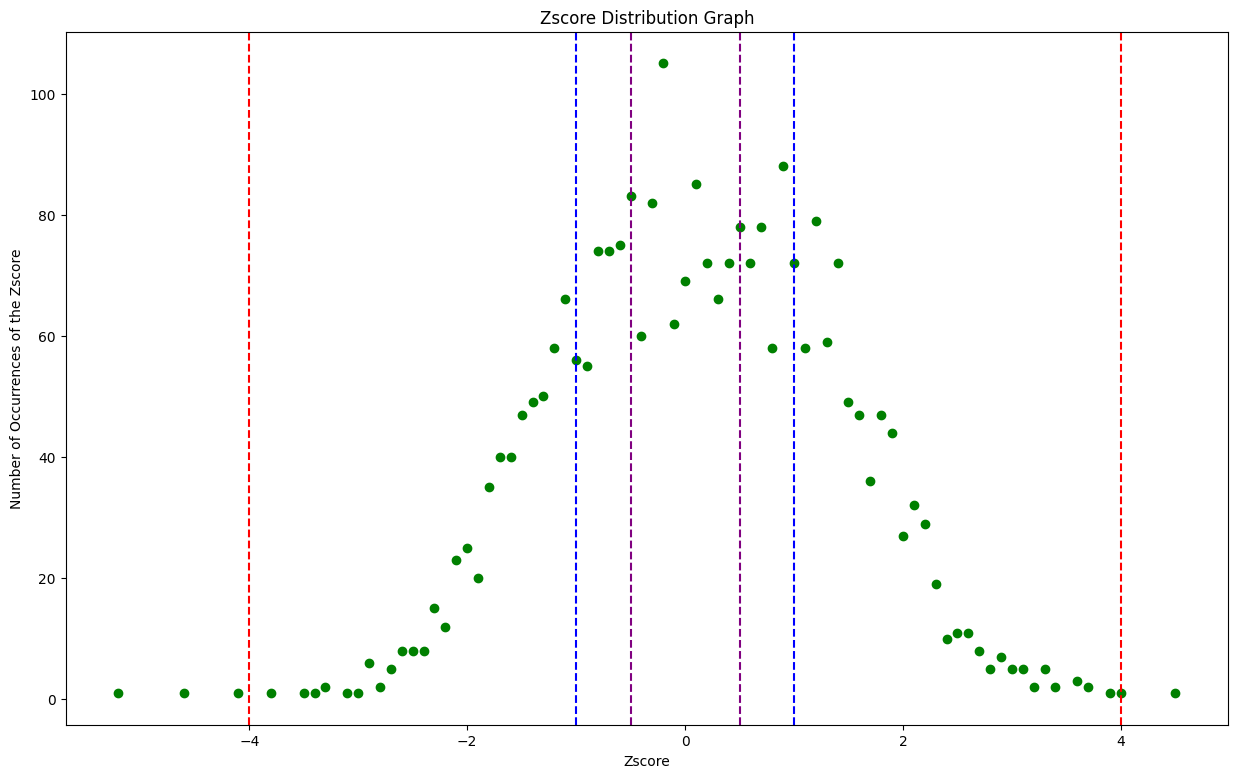

In [36]:
fig, ax = plt.subplots(figsize=(15, 9))
for z in zscore_freq:
    ax.plot(z, zscore_freq[z], 'go')

ax.axvline(x = -1, color='blue', linestyle='--')
ax.axvline(x = 1, color='blue', linestyle='--')
ax.axvline(x = -0.5, color='purple', linestyle='--')
ax.axvline(x = 0.5, color='purple', linestyle='--')
ax.axvline(x = -4.0, color='red', linestyle='--')
ax.axvline(x = 4.0, color='red', linestyle='--')
ax.set_title('Zscore Distribution Graph')
ax.set_xlabel('Zscore')
ax.set_ylabel('Number of Occurrences of the Zscore')
fig.show()

# Experiments and Results

### Enhanced (OPTICS AND PCA) Random Alphas

Done!: 100%|██████████| 2/2 [38:44<00:00, 1162.15s/it]                       


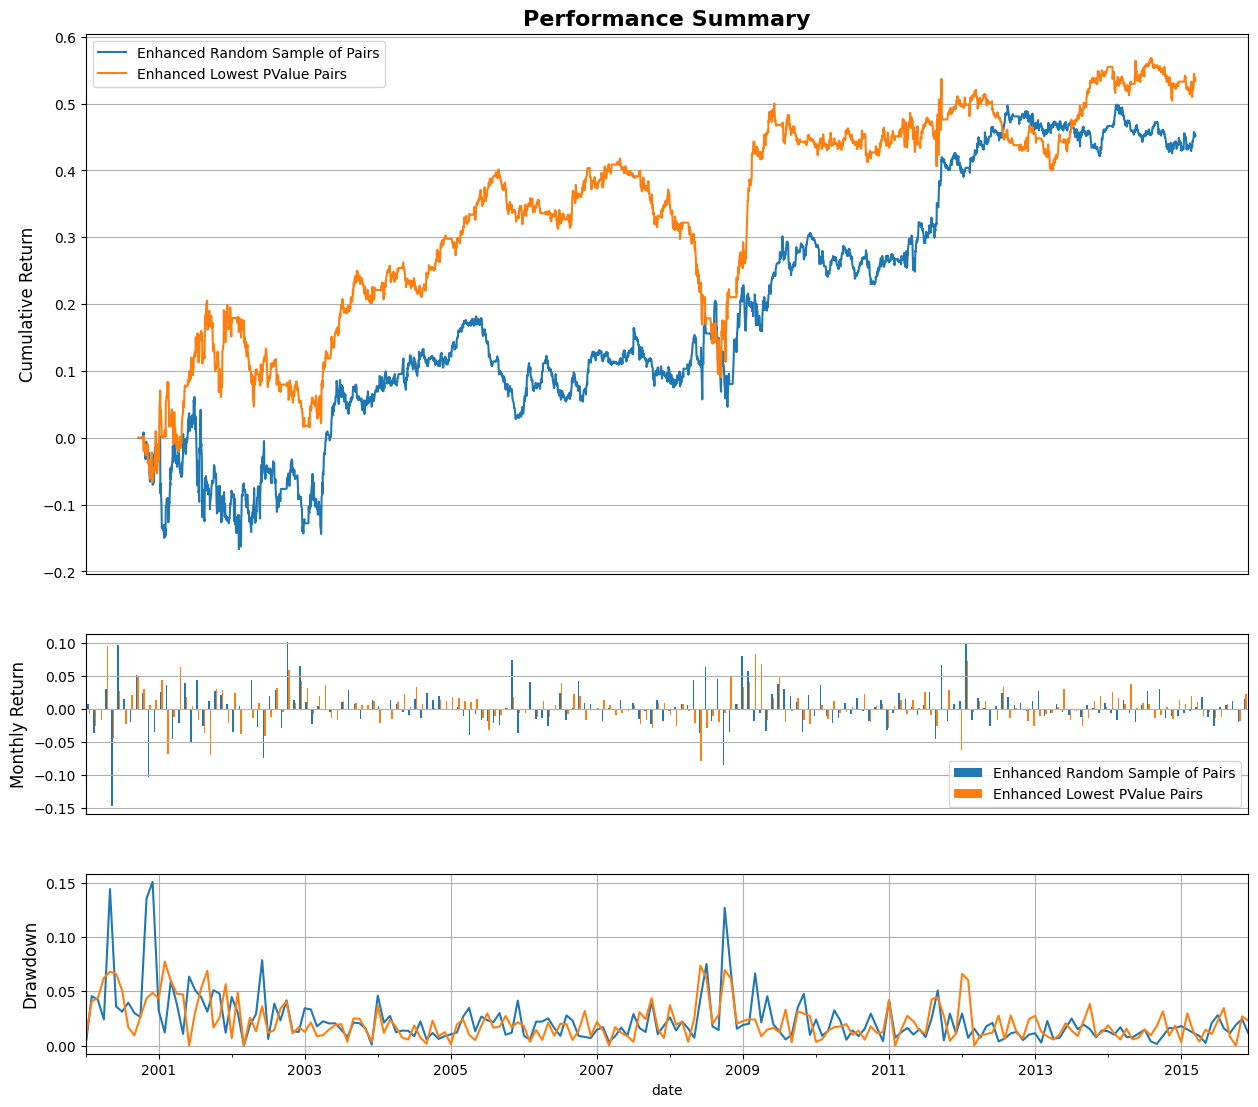

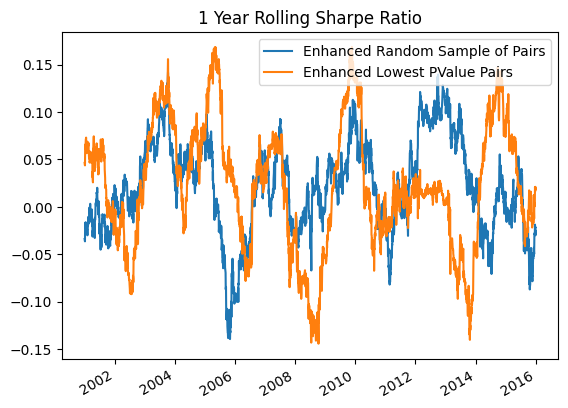

Enhanced Random Sample of Pairs


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000    -0.116167 -0.538800 -0.778749  0.172486  0.233648    7.170635   
2001     0.070498  0.390009  0.581102  0.124342  0.178771    6.274194   
2002     0.111507  0.906556  1.371979  0.108452  0.145394    5.658730   
2003     0.032764  0.409243  0.620639  0.050715  0.148111    6.888889   
2004     0.068969  0.976738  1.478612  0.046017  0.136683    7.079365   
2005    -0.092332 -1.484363 -2.192867  0.142705  0.166806    6.960317   
2006     0.055229  0.869289  1.530973  0.067292  0.176605    6.685259   
2007    -0.041183 -0.584148 -1.070485  0.083757  0.172895    6.195219   
2008    -0.000236 -0.001570 -0.002226  0.151382  0.133189    6.648221   
2009     0.189187  1.632717  2.505854  0.069017  0.176540    6.099206   
2010    -0.008234 -0.141762 -0.203423  0.067207  0.167388    6.686508   
2011     0.037414  0.488318  0.679550  0.053181  0.172374    6.734127   
2012     0.147859  1.808459  4.016530  0.035483  0.138060    6.480000   
2013     0.004346  0.081049  0.126949  0.045629  0.169521    6.785714   
2014     0.011673  0.234255  0.362808  0.050859  0.151029    7.226190   
2015    -0.019870 -0.401502 -0.663184  0.046381  0.119963    6.773810   
Overall  0.451424  0.266790  0.364566  0.218896  0.227643    6.647205   

         short count  
year                  
2000        6.170635  
2001        5.274194  
2002        4.658730  
2003        5.888889  
2004        6.079365  
2005        5.960317  
2006        5.685259  
2007        5.195219  
2008        5.648221  
2009        5.099206  
2010        5.686508  
2011        5.734127  
2012        5.480000  
2013        5.785714  
2014        6.226190  
2015        5.773810  
Overall     5.647205


Enhanced Lowest PValue Pairs


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.126166  0.736964  0.985495  0.102050  0.322775    7.063492   
2001    -0.032125 -0.203918 -0.296805  0.154828  0.198377    6.532258   
2002     0.067935  0.676799  1.053800  0.098963  0.147191    6.400794   
2003     0.093570  1.287501  1.960986  0.048123  0.160257    7.087302   
2004     0.067730  1.144211  1.852874  0.051128  0.146521    6.857143   
2005     0.021622  0.338494  0.488230  0.079492  0.150699    6.837302   
2006     0.041455  0.605877  0.959415  0.043012  0.182603    6.501992   
2007    -0.037695 -0.590460 -0.748097  0.098519  0.213045    6.852590   
2008    -0.138218 -0.810768 -1.222675  0.251510  0.133871    6.300395   
2009     0.232606  2.118965  3.788759  0.060576  0.156370    5.420635   
2010     0.011698  0.201755  0.308641  0.030756  0.227202    6.103175   
2011     0.014433  0.156218  0.182388  0.057552  0.230671    6.250000   
2012     0.015744  0.091556  0.115648  0.065894  0.155220    5.968000   
2013    -0.043278 -0.818888 -1.139944  0.083983  0.186438    6.107143   
2014     0.074902  1.268345  1.739931  0.042291  0.217264    6.607143   
2015     0.020719  0.304275  0.496401  0.061781  0.175414    6.623016   
Overall  0.537264  0.316610  0.425326  0.286480  0.249129    6.469565   

         short count  
year                  
2000        6.063492  
2001        5.532258  
2002        5.400794  
2003        6.087302  
2004        5.857143  
2005        5.837302  
2006        5.501992  
2007        5.852590  
2008        5.300395  
2009        4.420635  
2010        5.103175  
2011        5.250000  
2012        4.968000  
2013        5.107143  
2014        5.607143  
2015        5.623016  
Overall     5.469565

In [5]:
from sif.pairstrading.alphas import Enhanced_Random
from sif.pairstrading.alphas import Enhanced_Lowest_PValue

alphas = [Enhanced_Random(90, 10, 0.5), Enhanced_Lowest_PValue(90, 10, 0.5)]
returns, holdings = backtester_15y.backtest(alphas, processes=6)
metrics.summary_plot(returns, source=['Enhanced Random Sample of Pairs', 
                                      'Enhanced Lowest PValue Pairs'])
get_rolling_sharpe(returns)
get_analytics(alphas, returns, holdings)

## Alpha Search Optimization (Parameter Optimization)

Previously, we used a zscore of 0.5 as the open threshold and 1.0 as the close threshold for our trades, which is entirely arbitrary. While our intuition can have us use different open and close values based on what we think will work best, James and I both came up with different conclusions on our own. Rather than guessing and moving forward, let us Alpha Search from our SIF Infrastructure to test multiple values of our exit condition simultaneously with multiprocessing. A demo on parameter optimization can be found in the SIF Docs.

Done!: 100%|██████████| 18/18 [2:52:14<00:00, 574.15s/it]


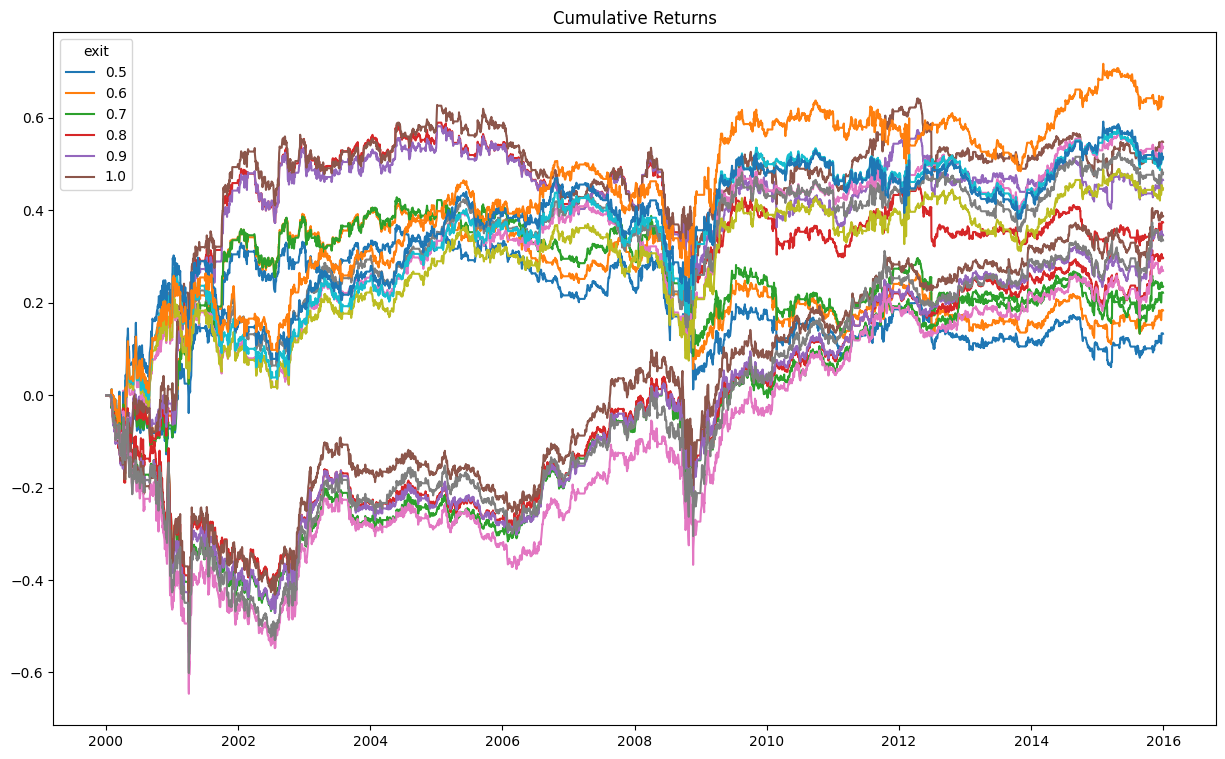

In [6]:
from sif.pairstrading.alphas import Enhanced_Lowest_PValue
param_grid = {'reset': [60, 90, 150], 'npairs': [10], 'exit': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
result = alpha_search.grid_search(Enhanced_Lowest_PValue, backtester_15y, 'return', param_grid, processes=6)

fig, ax = plt.subplots(figsize=(15,9))
ax.plot(result.alpha_returns.cumsum())
plt.legend(param_grid['exit'], title='exit')
plt.title('Cumulative Returns')
plt.show()

## Further Improvements

### Adding a Stop Loss - Enhanced Lowest PValue Alphas with a Stop Loss Condition

See alphas.py for implementation

In [12]:
# *** IN SAMPLE BACKTESTER WITH UNIVERSE REBALANCING *** #
start_date_15y = datetime.datetime(2000, 1, 1)
end_date_15y = datetime.datetime(2015, 12, 31)
# backtester_15y = fb.FullMultipleBacktester(
#     start_date_15y,

#     end_date_15y,
#     'M',
#     273,
#     universe_size = 500, 
#     factors=['close', 'sector']
# )

# backtester_15y.save_local('pairs_15y.npy')
single_backtester_15y = fb.FullSingleBacktester.from_local('singlebacktester2_15y.npy')

In [13]:
sret, shol = single_backtester_15y.backtest(Enhanced_Noncolinear_Stop_Lowest_PValue1(90, 10, 0.5, 3.5))

2015-12-31 00:00:00: 100%|███████████████████████████████████████████████████████| 4025/4025 [1:16:28<00:00,  1.14s/it]


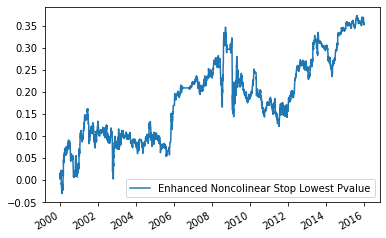

return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.029039  0.293494  0.530302  0.081454  0.207940    5.384921   
2001     0.104193  1.101280  1.541229  0.087487  0.186985    5.770161   
2002    -0.059367 -0.603430 -0.717854  0.124376  0.176514    5.067460   
2003     0.009168  0.119360  0.170478  0.046114  0.160419    4.404762   
2004     0.015185  0.231378  0.357920  0.055159  0.120667    2.257937   
2005     0.070898  1.071637  1.439784  0.052680  0.136133    2.694444   
2006     0.053398  1.528610  2.237489  0.017038  0.115089    3.007968   
2007     0.008854  0.175999  0.206508  0.041584  0.213253    4.127490   
2008     0.067314  0.622521  0.912583  0.111910  0.164143    3.114625   
2009    -0.111670 -0.767618 -0.770239  0.168835  0.159467    4.730159   
2010    -0.017379 -0.266567 -0.274628  0.104395  0.236933    2.678571   
2011    -0.007892 -0.105193 -0.146181  0.064747  0.147600    2.698413   
2012     0.091626  1.667115  2.774084  0.023827  0.164651    2.768000   
2013     0.048154  0.639291  1.224874  0.045005  0.211410    4.103175   
2014     0.041010  0.740186  1.109405  0.069299  0.248816    4.293651   
2015     0.011604  0.344959  0.538143  0.022702  0.168800    4.646825   
Overall  0.354136  0.276500  0.345706  0.213105  0.175422    3.857888   

         short count  
year                  
2000        4.384921  
2001        4.770161  
2002        4.067460  
2003        3.404762  
2004        1.257937  
2005        1.694444  
2006        2.007968  
2007        3.127490  
2008        2.114625  
2009        3.730159  
2010        1.678571  
2011        1.698413  
2012        1.768000  
2013        3.103175  
2014        3.293651  
2015        3.646825  
Overall     2.857888

In [22]:
fig, ax = plt.subplots(1)
sret.cumsum().plot(ax=ax, label="Enhanced Noncolinear Stop Lowest Pvalue", legend=True)
plt.show()
metrics.generate_performance_table(sret, shol)


In [8]:
from pairs.alphas import Enhanced_Noncolinear_Stop_Lowest_PValue1

alphas = [Enhanced_Noncolinear_Stop_Lowest_PValue1(90, 10, 0.5, 3.5)]

returns, holdings = backtester_15y.backtest(alphas, processes=None)

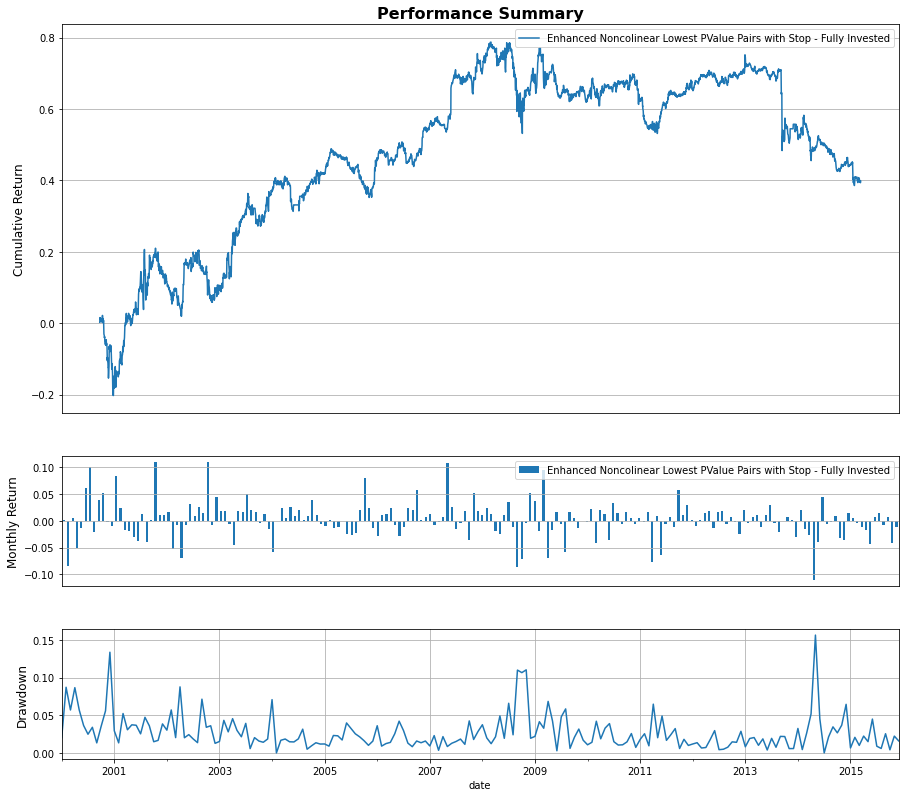

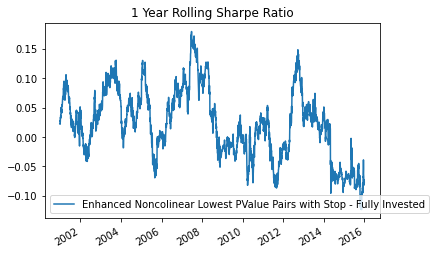

Enhanced Noncolinear Lowest PValue Pairs with Stop - Fully Invested


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.078513  0.352270  0.608114  0.205606  0.202499    6.503968   
2001     0.108700  0.757564  1.369185  0.177348  0.175878    7.032258   
2002     0.105012  0.729308  1.139363  0.138215  0.193375    5.202381   
2003     0.096571  0.920485  1.431703  0.088489  0.177305    3.698413   
2004     0.081022  0.932972  1.170048  0.070658  0.151582    4.023810   
2005     0.001943  0.025213  0.043151  0.114526  0.245173    5.309524   
2006     0.082888  1.210158  1.669898  0.067483  0.230408    5.697211   
2007     0.175604  1.643451  3.847010  0.066581  0.214815    5.239044   
2008    -0.072812 -0.349541 -0.468050  0.237746  0.181361    4.185771   
2009    -0.015599 -0.118053 -0.146373  0.144713  0.150957    5.492063   
2010     0.031125  0.379460  0.626143  0.075670  0.218014    4.305556   
2011    -0.027125 -0.258708 -0.360622  0.156415  0.236850    3.996032   
2012     0.023894  0.417447  0.620848  0.037853  0.165381    6.008000   
2013     0.043874  0.685499  1.314819  0.052792  0.164771    6.563492   
2014    -0.226014 -1.278613 -1.344383  0.241479  0.103605    4.019841   
2015    -0.089668 -1.214842 -1.206210  0.132392  0.177162    5.964286   
Overall  0.397929  0.197158  0.258748  0.369930  0.253220    5.200000   

         short count  
year                  
2000        5.503968  
2001        6.032258  
2002        4.202381  
2003        2.698413  
2004        3.023810  
2005        4.309524  
2006        4.697211  
2007        4.239044  
2008        3.185771  
2009        4.492063  
2010        3.305556  
2011        2.996032  
2012        5.008000  
2013        5.563492  
2014        3.019841  
2015        4.964286  
Overall     4.200000

In [9]:
metrics.summary_plot(returns, source=['Enhanced Noncolinear Lowest PValue Pairs with Stop - Fully Invested'])
get_rolling_sharpe(returns)
get_analytics(alphas, returns, holdings)

## Testing2 - Alpha For Parameter Optimization

See alphas.py for implementation

0:   0%|          | 0/9 [00:00<?, ?it/s]

Done!: 100%|██████████| 9/9 [2:58:47<00:00, 1191.99s/it]


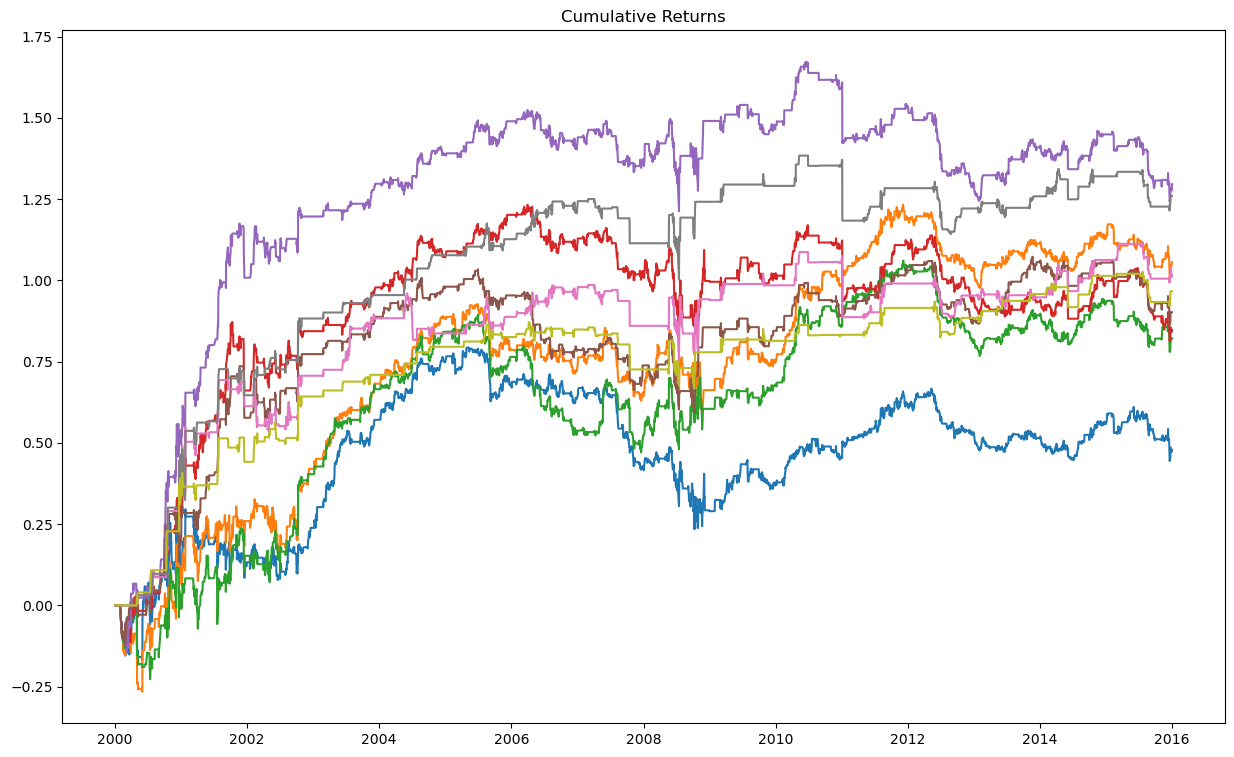

{'results':    param_reset  param_npairs  param_enter  param_exit  param_stop  \
0           90            10          2.0         1.0         3.5   
1           90            10          2.0         1.5         3.5   
2           90            10          2.0         2.0         3.5   
3           90            10          2.5         1.0         3.5   
4           90            10          2.5         1.5         3.5   
5           90            10          2.5         2.0         3.5   
6           90            10          3.0         1.0         3.5   
7           90            10          3.0         1.5         3.5   
8           90            10          3.0         2.0         3.5   

                                              params     score  
0  {'reset': 90, 'npairs': 10, 'enter': 2, 'exit'...  0.478173  
1  {'reset': 90, 'npairs': 10, 'enter': 2, 'exit'...  1.056056  
2  {'reset': 90, 'npairs': 10, 'enter': 2, 'exit'...  0.821878  
3  {'reset': 90, 'npairs': 10, 'enter

In [6]:
from sif.pairstrading.alphas import Testing2
param_grid = {'reset': [90], 'npairs': [10], 'enter': [2, 2.5, 3], 'exit': [1.0, 1.5, 2], 'stop': [3.5]}
result = alpha_search.grid_search(Testing2, backtester_15y, 'return', param_grid, processes=6)

fig, ax = plt.subplots(figsize=(15,9))
ax.plot(result.alpha_returns.cumsum())
# plt.legend(param_grid[('exit')], title='exit')
plt.title('Cumulative Returns')
plt.show()

In [7]:
result.__dict__

{'results':    param_reset  param_npairs  param_enter  param_exit  param_stop  \
 0           90            10          2.0         1.0         3.5   
 1           90            10          2.0         1.5         3.5   
 2           90            10          2.0         2.0         3.5   
 3           90            10          2.5         1.0         3.5   
 4           90            10          2.5         1.5         3.5   
 5           90            10          2.5         2.0         3.5   
 6           90            10          3.0         1.0         3.5   
 7           90            10          3.0         1.5         3.5   
 8           90            10          3.0         2.0         3.5   
 
                                               params     score  
 0  {'reset': 90, 'npairs': 10, 'enter': 2, 'exit'...  0.478173  
 1  {'reset': 90, 'npairs': 10, 'enter': 2, 'exit'...  1.056056  
 2  {'reset': 90, 'npairs': 10, 'enter': 2, 'exit'...  0.821878  
 3  {'reset': 90, 'npai

Testing2:   0%|          | 0/1 [00:00<?, ?it/s]

Done!: 100%|██████████| 1/1 [20:59<00:00, 1259.80s/it]


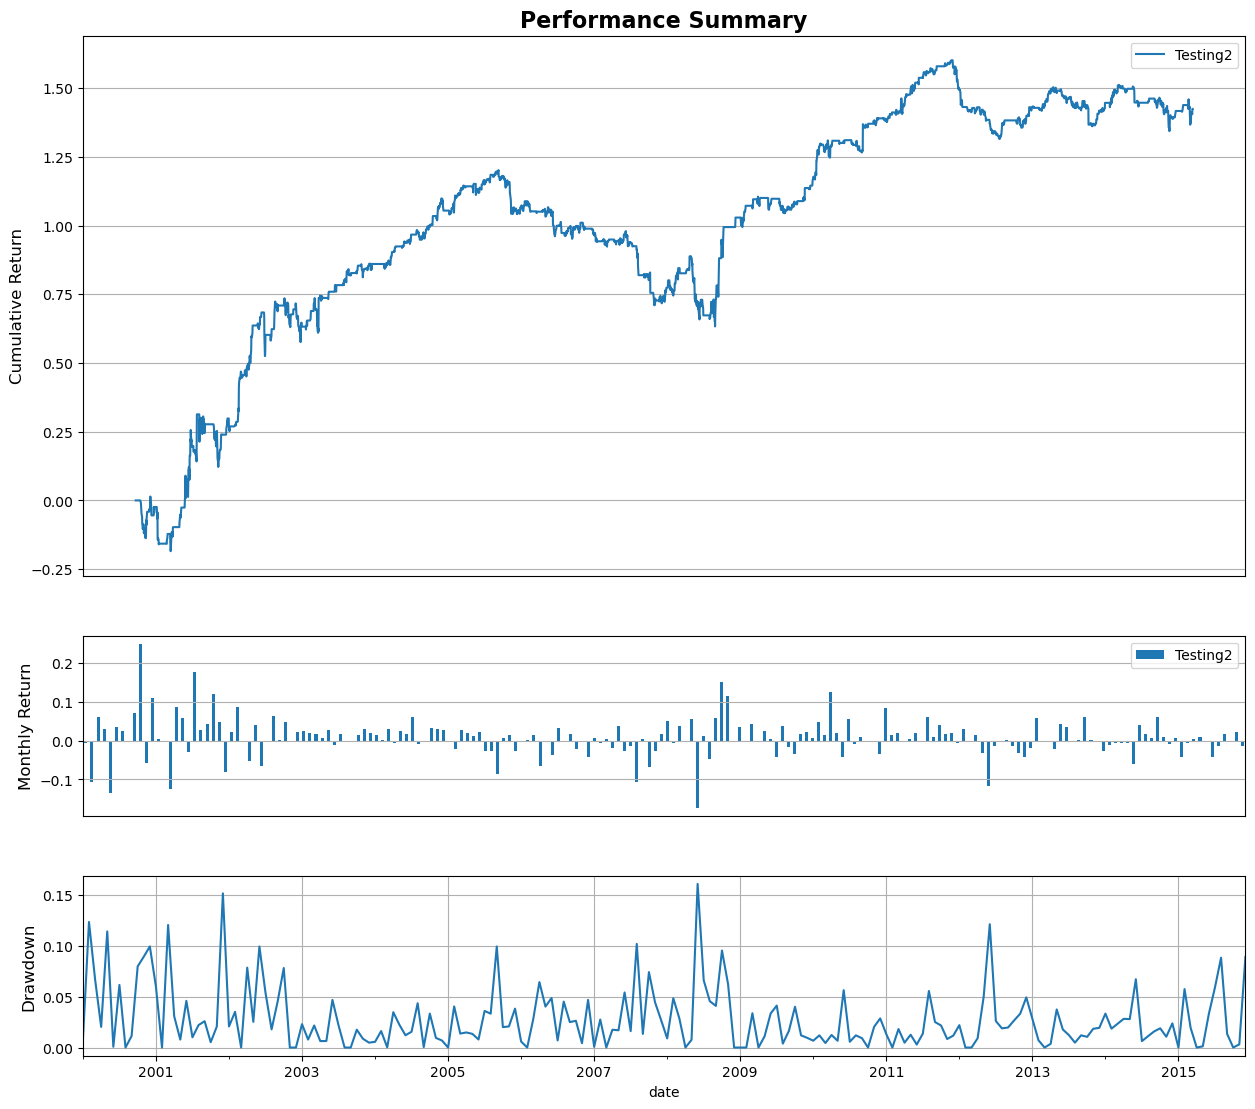

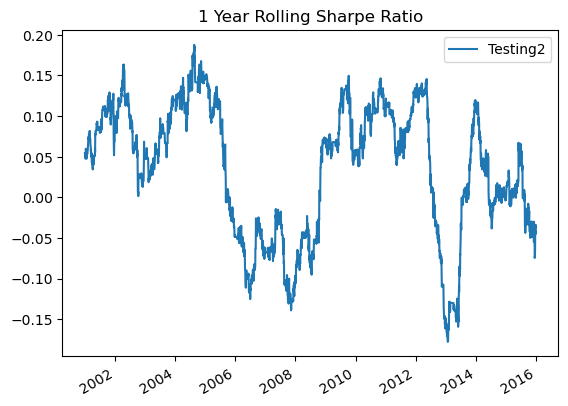

Testing2


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.272878  0.860043  1.289233  0.187530  0.182411    1.805556   
2001     0.329657  1.426032  1.960583  0.172419  0.194567    1.758065   
2002     0.157132  0.754886  1.287977  0.152397  0.202227    1.718254   
2003     0.164886  1.911090  3.026577  0.046892  0.141489    1.492063   
2004     0.218782  2.341265  3.400133  0.057024  0.250144    2.250000   
2005    -0.091103 -0.770819 -0.916217  0.150307  0.206356    2.325397   
2006    -0.108980 -1.079372 -1.212050  0.123235  0.168079    1.884462   
2007    -0.199254 -1.536767 -1.566341  0.241673  0.193376    1.924303   
2008     0.250986  1.060599  1.698408  0.233867  0.232833    1.865613   
2009     0.089284  0.884288  1.140489  0.060308  0.118956    1.718254   
2010     0.190620  1.635873  3.065155  0.061784  0.176950    1.591270   
2011     0.283705  2.069984  3.679503  0.055638  0.274859    1.833333   
2012    -0.214533 -2.421680 -2.761138  0.237131  0.178922    2.000000   
2013     0.145520  1.770083  3.332119  0.037480  0.221388    2.162698   
2014     0.003507  0.030899  0.036596  0.129813  0.180912    2.345238   
2015    -0.067958 -0.587732 -0.758577  0.153071  0.163150    1.603175   
Overall  1.425129  0.566155  0.794044  0.452866  0.222076    1.892422   

         short count  
year                  
2000        0.805556  
2001        0.758065  
2002        0.718254  
2003        0.492063  
2004        1.250000  
2005        1.325397  
2006        0.884462  
2007        0.924303  
2008        0.865613  
2009        0.718254  
2010        0.591270  
2011        0.833333  
2012        1.000000  
2013        1.162698  
2014        1.345238  
2015        0.603175  
Overall     0.892422

In [4]:
from sif.pairstrading.alphas import Testing2

alphas = [Testing2(90, 10, 2.25, 1.75, 3.5)]

returns, holdings = backtester_15y.backtest(alphas, processes=6)
metrics.summary_plot(returns, source=['Testing2'])
get_rolling_sharpe(returns)     
get_analytics(alphas, returns, holdings)

## Pair Validation Techniques: Hurst Exponent (And profitability)

https://www.sciencedirect.com/science/article/pii/S037843712100964X?via%3Dihub

The Hurst Exponent measures long term memory and fractility of a time series. A Brownian random process is given by a hurst exponent of exactly 0.5, while a hurst exponent between 0.5 and 1 indicates a trending behavior. If the metric is between 0 and 0.5, the time series exhibits a mean reverting behavior. This is optimal for a pairs trading strategy.

Since in general, a hurst exponent != 0.5 means that the time series exhibits some sort of predictable pattern, we can use this metric to better trade on trending/momentum strategies with large hurst exponents, or mean reverting strategies like pairs trading with low hurst exponents.

In the next Alpha, we implement Hurst Exponent as a Validation technique to insure the pair is mean reverting in addition to cointegrated. We can consider weighting / selecting final pairs based on hurst in a later alpha, but for now, we simply require a cutoff for the metric x, where x < 0.5.

The code for calculating hurst comes from here: https://stackoverflow.com/questions/39488806/hurst-exponent-in-python


HURST ON STOCKS

482 482
[0.48144515 0.2984089  0.37815051 0.38698298 0.45030502 0.58075875
 0.49961413 0.31982893 0.20190837 0.26541291 0.47369003 0.47265829
 0.38248461 0.50376813 0.40326177 0.26161414 0.49003071 0.34131983
 0.38380711 0.38642152 0.43879521 0.47765906 0.45307745 0.41096753
 0.33545483]
Mean: 0.3690262516946036
Min: -0.019756188364177238
Max: 0.6487146108643644
-0.019756188364177238
0.06921549557453438
0.08306626957374842
0.08751749492257245
0.09707956376054659
0.11872351824470707
0.1298493418448527


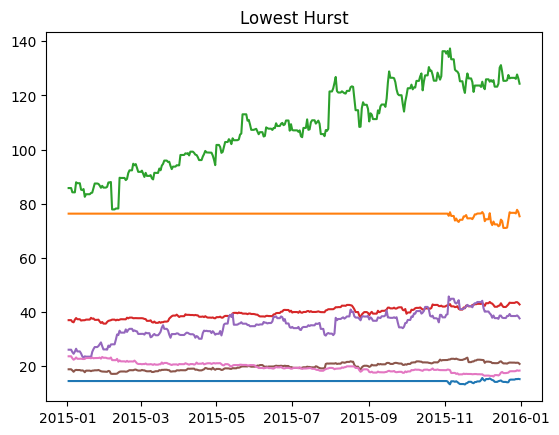

0.5761237520022302
0.5807587545828551
0.5977869733377005
0.6218814289301922
0.6258500325187214
0.6322225309126616
0.6487146108643644


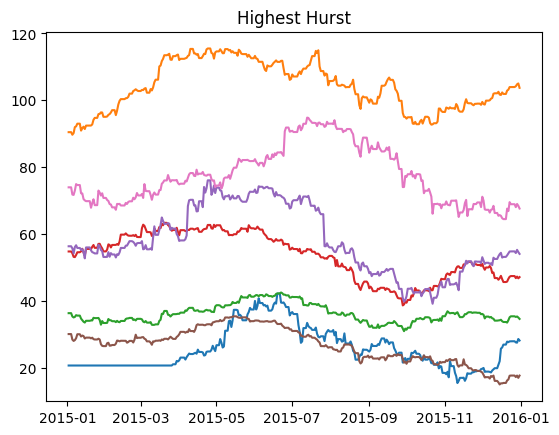

HURST ON PAIRS


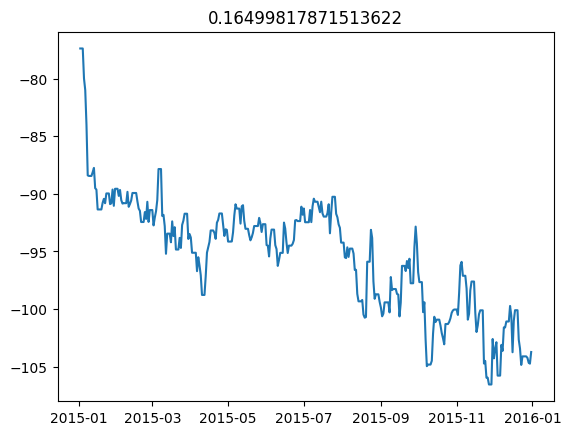

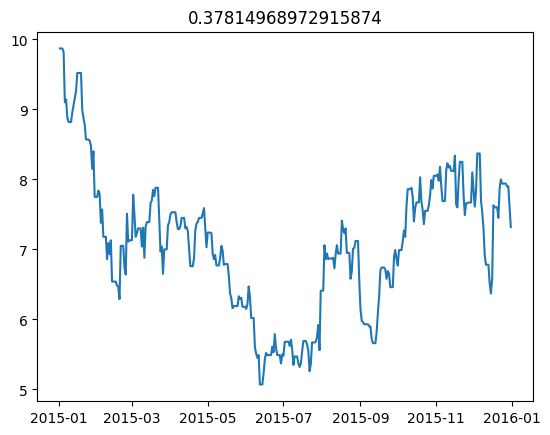

In [16]:
def hurst(p):
    lags = range(2,100)
    variancetau, tau = [], []
    for lag in lags: 
        tau.append(lag) # Write the different lags into a vector to compute a set of tau or lags
        
        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = np.subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    # plot the log of those variance against the log of tau and get the slope
    m = np.polyfit(np.log10(tau), np.log10(variancetau), 1)
    hurst = m[0] / 2
    return hurst

print("HURST ON STOCKS\n")
print(len(hurst(close_data)), len(close_data.columns)) # make sure function works properly
h_exp = hurst(close_data)
print(h_exp[:25])
print("Mean:", h_exp.mean())
print("Min:", h_exp.min())
print("Max:", h_exp.max())

indices = np.argsort(h_exp)[:7]
for i in indices:
    plt.plot(close_data.iloc[:, i])
    print(h_exp[i])
plt.title("Lowest Hurst")
plt.show()

indices2 = np.argsort(h_exp)[-7:]
for i in indices2:
    print(h_exp[i])
    plt.plot(close_data.iloc[:, i])
plt.title("Highest Hurst")
plt.show()

print("HURST ON PAIRS")
pair = ("ATVI", "STZ")
pair2 = ("AEE", "XEL")

tspair = close_data["ATVI"] - close_data["STZ"]
tspair2 = close_data["AEE"] - close_data["XEL"]
tspairs = (tspair, tspair2)

for i in tspairs:
    plt.plot(i)
    plt.title((hurst(list(i))))
    plt.show()

In [ ]:
# hursts = []
# start = time.perf_counter()
# for pair in new_dict:
#     spread = close_data[pair[0]] - close_data[pair[1]]
#     H, c, data = compute_Hc(spread, "change")
#     hursts.append(H)
# end = time.perf_counter()

# print(f"Imported Hurst Package time: {end-start}")
# print(hursts)

In [5]:
def hurst(p):
    lags = range(2,100)
    variancetau, tau = [], []
    for lag in lags: 
        tau.append(lag) # Write the different lags into a vector to compute a set of tau or lags
        
        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = np.subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    # plot the log of those variance against the log of tau and get the slope
    m = np.polyfit(np.log10(tau), np.log10(variancetau), 1)
    hurst = m[0] / 2
    return hurst

In [6]:
class HURST(AbstractAlpha):
    def __init__(self, reset, npairs, exit, stop, hurst):
        self.name = 'HURST'
        self.lookback = reset
        self.factor_list = ['close']
        self.universe_size = 500
        
        self.pairs = None
        self.print = False
        self.reset = reset
        self.npairs = npairs
        self.exit = exit
        self.stop = stop
        self.holdings = np.zeros(self.universe_size)
        self.day_counter = 0
        self.count = 0
        
        self.hurst = hurst # MAXIMUM Hurst Exponent. Recall 0.5 means that the series reflects brownian motion
        
    def hurst(self, p):
        lags = range(2,100)
        variancetau, tau = [], []

        for lag in lags: 
            tau.append(lag)

            # Compute the log returns on all days, then compute the variance on the difference in log returns
            # call this pp or the price difference
            pp = np.subtract(p[lag:], p[:-lag])
            variancetau.append(np.var(pp))

        # we now have a set of tau or lags and a corresponding set of variances.
        # plot the log of those variance against the log of tau and get the slope
        m = np.polyfit(np.log10(tau),np.log10(variancetau),1)
        hurst = m[0] / 2
        return hurst

    def zscore(self, series: array_1d) -> float:
        return (series - series.mean()) / np.std(series)

    def reduce_dimensionality(self, df: pd.DataFrame) -> pd.DataFrame:
        
        #note that we have to transpose rets to obtain a dataframe of shape n_samples, n_features
        rets = df.pct_change().dropna()
        rets = rets.T

        # use pca to reduce dimensionality to preserve at least 90% of original information
        pca = PCA(n_components = 0.9, svd_solver='full')
        transformed_data = pca.fit_transform(rets)
        
        if self.print:
            print("Shape of our data:", df.shape)
            print("Preserved Information:", sum(pca.explained_variance_ratio_))
            print("Number of Components:", pca.n_components_)
            print("Reduced dimensions shape of our new data:", transformed_data.shape)
        return transformed_data
    
    def cluster_optics(self, transformed_data: array_1d) -> array_1d:
        optics = OPTICS(min_samples = 2)
        labels = optics.fit_predict(transformed_data)

        if self.print:
            # Number of clusters in labels, ignoring noise if present.
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            clusters = {}
            for i in range(len(labels)):
                if labels[i] != -1:
                    clusters[labels[i]] = clusters.get(labels[i], 0) + 1
            print("Estimated number of clusters:", n_clusters)
            print("Estimated number of noise points:", n_noise)
            print("Number of securities per cluster:", clusters)
        return labels
    
    def form_pairs(self, df: pd.DataFrame) -> array_1d:
        df = pd.DataFrame(df).dropna()
        n = df.shape[1]

        # obtain transformed data and clusters using above functions
        transformed_data = self.reduce_dimensionality(df)
        labels = self.cluster_optics(transformed_data)

        # creating an adjacency matrix sort of for cointegration scores and pvalues
        keys = df.keys()
        pairs = []
        pairsDict = {} #maps from pvalue to pair
        for i in range(n):
            for j in range(i + 1, n):
                
                # assert that both stocks are in the same cluster and not outliers
                if labels[i] != -1 and labels[j] != -1 and labels[i] == labels[j]:
                    S1 = df[keys[i]]        
                    S2 = df[keys[j]]
                    result = coint(S1, S2)
                    pvalue = result[1]
                    
                    # used a hashmap, sorted keys (pvalues) in ascending order in order
                    # to get the smallest pvalues
                    if pvalue < 0.05:
                        # NEW: CHECK HURST EXPONENT
                        h_exp = hurst(list(S1-S2))
                        pairsDict[(i, j)] = h_exp
        
        # sort the pairs by lowest p-value
        keys, values = list(pairsDict.keys()), list(pairsDict.values())
        sorted_value_index = np.argsort(values)
        sorted_dict = {keys[i]: values[i] for i in sorted_value_index}

        # a stock should only be included once in our holdings to prevent mishaps
        new_dict, seen = {}, set()
        for (i, j) in sorted_dict:
            if i not in seen and j not in seen:
                new_dict[(i, j)] = sorted_dict[(i,j)]
                seen.add(i)
                seen.add(j)
        
        # choose 10 pairs if possible
        if len(new_dict) < self.npairs:
            pairs = list(new_dict.keys())
        else:
            pairs = list((new_dict.keys()))[0:self.npairs]
            
        if self.print:
            print(f"PValue Cointegrated Pairs - Round {self.count} - Pairs are {pairs}")
            print()
            self.count += 1
        return pairs
    
#     def ratio_function(self, num1: float, num2: float) -> array_1d:
#         gcd = math.gcd(int(num1), int(num2))
#         return num1/gcd, num2/gcd
    
    def generate_day(self, day: date_obj, data: pd.DataFrame) -> array_1d:
        
        # creating new pairs
        if self.day_counter == 0:
            self.day_counter = self.reset
            self.pairs = self.form_pairs(data['close'])
            self.holdings = np.zeros(self.universe_size)
      
        data = pd.DataFrame(data["close"])
        pairs_selected = []
        for p in self.pairs:
            FIRST, SECOND = p[0], p[1]
            spread = data[FIRST] - data[SECOND]
            
            #zscore tells us how far from away from the mean a data point is
            z_score = self.zscore(spread).tail(1).values[0]
            
            # enter the trade, short the FIRST, long SECOND
            if z_score > 1.0 and z_score <= self.stop:
                self.holdings[FIRST] = -1
                self.holdings[SECOND] = 1
                
            # exit the trade
            elif abs(z_score) <= self.exit:
                self.holdings[FIRST] = 0
                self.holdings[SECOND] = 0
            
            # ensure that the pair is still cointegrated, otherwise eat the losses before it gets worse
            elif abs(z_score) > self.stop:
                temp = data.dropna()
                S1, S2 = temp[FIRST], temp[SECOND]
                result = coint(S1, S2)
                pvalue = result[1]
                if pvalue >= 0.05:
                    self.holdings[FIRST] = 0
                    self.holdings[SECOND] = 0
                    self.pairs.remove(p)

            # enter the trade; long the FIRST, short SECOND
            elif z_score < -1.0 and z_score >= -self.stop:
                self.holdings[FIRST] = 1
                self.holdings[SECOND] = -1
            
        # at the end of the trading day, decrement day_counter
        self.day_counter -= 1
        return op.weight(self.holdings)

In [ ]:
alphas = [HURST(90, 10, 1.0, 3.5, 0.5)]
returns, holdings = backtester_15y.backtest(alphas, processes=6)
metrics.summary_plot(returns, source=['HURST'])
get_rolling_sharpe(returns)
get_analytics(returns, holdings)

HURST:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

In [ ]:
class HURST_Sort(AbstractAlpha):
    def __init__(self, reset, npairs, exit, stop, hurst):
        self.name = 'HURST Sort'
        self.lookback = reset
        self.factor_list = ['close']
        self.universe_size = 500
        
        self.pairs = None
        self.print = False
        self.reset = reset
        self.npairs = npairs
        self.exit = exit
        self.stop = stop
        self.holdings = np.zeros(self.universe_size)
        self.day_counter = 0
        self.count = 0
        
        self.hurst = hurst # MAXIMUM Hurst Exponent. Recall 0.5 means that the series reflects brownian motion

    def zscore(self, series: array_1d) -> float:
        return (series - series.mean()) / np.std(series)

    def reduce_dimensionality(self, df: pd.DataFrame) -> pd.DataFrame:
        
        #note that we have to transpose rets to obtain a dataframe of shape n_samples, n_features
        rets = df.pct_change().dropna()
        rets = rets.T

        # use pca to reduce dimensionality to preserve at least 90% of original information
        pca = PCA(n_components = 0.9, svd_solver='full')
        transformed_data = pca.fit_transform(rets)
        
        if self.print:
            print("Shape of our data:", df.shape)
            print("Preserved Information:", sum(pca.explained_variance_ratio_))
            print("Number of Components:", pca.n_components_)
            print("Reduced dimensions shape of our new data:", transformed_data.shape)
        return transformed_data
    
    def cluster_optics(self, transformed_data: array_1d) -> array_1d:
        optics = OPTICS(min_samples = 2)
        labels = optics.fit_predict(transformed_data)

        if self.print:
            # Number of clusters in labels, ignoring noise if present.
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            clusters = {}
            for i in range(len(labels)):
                if labels[i] != -1:
                    clusters[labels[i]] = clusters.get(labels[i], 0) + 1
            print("Estimated number of clusters:", n_clusters)
            print("Estimated number of noise points:", n_noise)
            print("Number of securities per cluster:", clusters)
        return labels
    
    def form_pairs(self, df: pd.DataFrame) -> array_1d:
        df = pd.DataFrame(df).dropna()
        n = df.shape[1]

        # obtain transformed data and clusters using above functions
        transformed_data = self.reduce_dimensionality(df)
        labels = self.cluster_optics(transformed_data)

        # creating an adjacency matrix sort of for cointegration scores and pvalues
        pvalue_matrix = np.ones((n, n))
        keys = df.keys()
        pairs = []
        pairsDict = {} #maps from pvalue to pair
        for i in range(n):
            for j in range(i + 1, n):
                
                # assert that both stocks are in the same cluster and not outliers
                if labels[i] != -1 and labels[j] != -1 and labels[i] == labels[j]:
                    S1 = df[keys[i]]        
                    S2 = df[keys[j]]
                    result = coint(S1, S2)
                    pvalue = result[1]
                    
                    # used a hashmap, sorted keys (pvalues) in ascending order in order
                    # to get the smallest pvalues
                    if pvalue < 0.05:
                        # NEW: CHECK HURST EXPONENT
                        h_exp, c, data = compute_Hc(S1 - S2, 'change')
                        pairsDict[(i, j)] = h_exp
        
        # sort the pairs by lowest p-value
        keys, values = list(pairsDict.keys()), list(pairsDict.values())
        sorted_value_index = np.argsort(values)
        sorted_dict = {keys[i]: values[i] for i in sorted_value_index}

        # a stock should only be included once in our holdings to prevent mishaps
        new_dict, seen = {}, set()
        for (i, j) in sorted_dict:
            if i not in seen and j not in seen:
                new_dict[(i, j)] = sorted_dict[(i,j)]
                seen.add(i)
                seen.add(j)
        
        # choose 10 pairs if possible
        if len(new_dict) < self.npairs:
            pairs = list(new_dict.keys())
        else:
            pairs = list((new_dict.keys()))[0:self.npairs]
            
        if self.print:
            print(f"PValue Cointegrated Pairs - Round {self.count} - Pairs are {pairs}")
            print()
            self.count += 1
        return pairs
    
#     def ratio_function(self, num1: float, num2: float) -> array_1d:
#         gcd = math.gcd(int(num1), int(num2))
#         return num1/gcd, num2/gcd
    
    def generate_day(self, day: date_obj, data: pd.DataFrame) -> array_1d:
        
        # creating new pairs
        if self.day_counter == 0:
            self.day_counter = self.reset
            self.pairs = self.form_pairs(data['close'])
            self.holdings = np.zeros(self.universe_size)
      
        data = pd.DataFrame(data["close"])
        pairs_selected = []
        for p in self.pairs:
            FIRST, SECOND = p[0], p[1]
            spread = data[FIRST] - data[SECOND]
            
            #zscore tells us how far from away from the mean a data point is
            z_score = self.zscore(spread).tail(1).values[0]
            
            # enter the trade, short the FIRST, long SECOND
            if z_score > 1.0 and z_score <= self.stop:
                self.holdings[FIRST] = -1
                self.holdings[SECOND] = 1
                
            # exit the trade
            elif abs(z_score) <= self.exit:
                self.holdings[FIRST] = 0
                self.holdings[SECOND] = 0
            
            # ensure that the pair is still cointegrated, otherwise eat the losses before it gets worse
            elif abs(z_score) > self.stop:
                temp = data.dropna()
                S1, S2 = temp[FIRST], temp[SECOND]
                result = coint(S1, S2)
                pvalue = result[1]
                if pvalue >= 0.05:
                    self.holdings[FIRST] = 0
                    self.holdings[SECOND] = 0
                    self.pairs.remove(p)

            # enter the trade; long the FIRST, short SECOND
            elif z_score < -1.0 and z_score >= -self.stop:
                self.holdings[FIRST] = 1
                self.holdings[SECOND] = -1
            
        # at the end of the trading day, decrement day_counter
        self.day_counter -= 1
        return op.weight(self.holdings)

In [ ]:
alphas = [HURST_Sort(90, 10, 1.0, 3.5, 0.5)]
returns, holdings = backtester_15y.backtest(alphas, processes=6)
metrics.summary_plot(returns, source=['HURST Sort'])
get_rolling_sharpe(returns)
get_analytics(returns, holdings)

## Traced - Checking Alpha's performance manually

Throughout our development process, we repeatedly ran into bugs where the pairs trading was not actually working the way it shold have. For example, we may have not actually been opening trades when the threshold was reached, or not properly exiting when we wanted to. To remedy this, we created an alpha that displays the zscore and closing prices as it runs, allowing us to check that our implementation is working as expected. This was immensely useful for making sure our final alpha is bug free

In [17]:
class Traced(AbstractAlpha):
    def __init__(self, reset, npairs, enter, exit, stop):
        self.name = 'Traced'
        self.lookback = reset
        self.factor_list = ['close']
        self.universe_size = 500
        
        self.pairs = None
        self.print = True
        self.reset = reset
        self.npairs = npairs
        self.enter = enter
        self.exit = exit
        self.stop = stop
        self.holdings = np.zeros(self.universe_size)
        self.period = 1
        self.day = 0
        self.day_counter = 0
        self.factors = ['Zscore', 'Close Prices', 'Spread']
        self.factor_data = {factor:pd.DataFrame(np.zeros((self.reset, self.npairs))) for factor in self.factors}

    def zscore(self, series):
        return (series - series.mean()) / np.std(series)
    
    def form_pairs(self, df):
        df= pd.DataFrame(df)
        clustering_df = df.dropna()
        n = df.shape[1]
        # obtain transformed data and clusters using above functions
        transformed_data = self.reduce_dimensionality(clustering_df)
        labels = self.cluster_optics(transformed_data)
        pvalue_matrix = np.ones((n, n))
        keys = df.keys()
        pairs = []
        pairsDict = {} #maps from pvalue to pair
        for i in range(n):
            for j in range(i + 1, n):
                if labels[i] != -1 and labels[j] != -1 and labels[i] == labels[j]:
                    S1 = df[keys[i]]
                    S2 = df[keys[j]]
                    coint_df = pd.DataFrame({'S1': S1, 'S2': S2}).dropna()
                    S1 = coint_df['S1']
                    S2 = coint_df['S2']
                    result = coint(S1, S2)
                    pvalue = result[1]
                    pvalue_matrix[i, j] = pvalue
                    # used a hashmap, sorted keys (pvalues) in ascending order in order
                    # to get the smallest pvalues
                    if pvalue < 0.05 and pvalue != 0.0:
                        pairsDict[(i,j)] = pvalue
        
        # sort the pairs by lowest p-value
        keys, values = list(pairsDict.keys()), list(pairsDict.values())
        sorted_value_index = np.argsort(values)
        sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
        
        # a stock should only be included once in our holdings to prevent mishaps
        new_dict, seen = {}, set()
        for (i, j) in sorted_dict:
            if i not in seen and j not in seen:
                new_dict[(i, j)] = sorted_dict[(i,j)]
                seen.add(i)
                seen.add(j)
        
        # obtain top npairs pairs if possible
        pairs = list(new_dict.keys()) if len(new_dict) < self.npairs else list((new_dict.keys()))[0:self.npairs]
        return pairs
    
    def reduce_dimensionality(self, df: pd.DataFrame) -> pd.DataFrame:
        rets = df.pct_change().dropna()
        rets = rets.T
        pca = PCA(n_components = 0.9, svd_solver='full')
        transformed_data = pca.fit_transform(rets)
        return transformed_data
        
    def cluster_optics(self, transformed_data: array_1d) -> array_1d:
        optics = OPTICS(min_samples = 2)
        labels = optics.fit_predict(transformed_data)
        return labels

    def make_factors(self):
        self.factor_data = {factor:pd.DataFrame(np.zeros((self.reset, len(self.pairs)))) for factor in self.factors}
        for factor in self.factor_data:
            self.factor_data[factor] = self.factor_data[factor].set_axis(self.pairs, axis="columns")
            new_axis = [i for i in range(self.reset)]
            self.factor_data[factor] = self.factor_data[factor].set_axis(new_axis, axis="rows")
            self.factor_data[factor] = self.factor_data[factor].rename_axis(f"{factor} of Pairs", axis="columns")

    def generate_day(self, day, data):
        
        # print factor data if its the end of the window
        if self.day == 90:
            self.day = 0
            if self.print:
                for factor in self.factors:
                    print(f"Trading Window {self.period}: {factor}")
                    print(self.factor_data[factor].to_markdown())
                    print()
            self.period += 1

        # creating new pairs
        if self.day_counter == 0:
            self.day_counter = self.reset
            self.holdings = np.zeros(self.universe_size)
            self.pairs = self.form_pairs(data['close'])
            self.factor_data = {factor:pd.DataFrame(np.zeros((self.reset, self.npairs))) for factor in self.factors}
            self.make_factors()
      
        data = pd.DataFrame(data['close']).fillna(method="ffill").fillna(method="bfill")
        # print(len(data))
        
        for p in self.pairs:

            # *** FACTOR DATA *** #
            FIRST, SECOND = p[0], p[1]
            spread = data[FIRST] - data[SECOND]
            z_score = self.zscore(spread).tail(1).values[0]
            diff = spread[day]
            close_price = ({round(data[p[0]][day], 2)} , {round(data[p[1]][day], 2)})

            for factor in self.factors:
                # add to dataframes
                if factor == 'Zscore':
                    if z_score >= self.enter and z_score < self.stop:
                        # update current trade status
                        self.factor_data[factor][p][self.day] = f"OPEN {round(z_score, 2)}"

                    # exit the trade; dont increment anything
                    elif abs(z_score) <= self.exit:
                        self.factor_data[factor][p][self.day] = f"CLOSED {round(z_score, 2)}"

                    # enter the trade; long the FIRST, short SECOND
                    elif z_score <= -self.enter and z_score >= -self.stop:
                        self.factor_data[factor][p][self.day] = f"OPEN {round(z_score, 2)}"
                
                elif factor == 'Close Prices':
                    self.factor_data[factor][p][self.day] = close_price
                    # print(self.factor_data[factor][p][day])
                    
                elif factor == 'Spread':
                    self.factor_data[factor][p][self.day] = round(diff, 2)
                    
            if z_score >= self.enter and z_score <= self.stop:
                    self.holdings[FIRST] = -1
                    self.holdings[SECOND] = 1
                
            # exit the trade
            elif abs(z_score) < self.exit:
                self.holdings[FIRST] = 0
                self.holdings[SECOND] = 0
            
            # ensure that the pair is still cointegrated, otherwise eat the losses before it gets worse
            elif abs(z_score) > self.stop:
                temp = data.dropna()
                S1, S2 = temp[FIRST], temp[SECOND]
                result = coint(S1, S2)
                pvalue = result[1]
                if pvalue >= 0.05:
                    self.holdings[FIRST] = 0
                    self.holdings[SECOND] = 0
                    self.pairs.remove(p)

            # enter the trade; long the FIRST, short SECOND
            elif z_score <= -self.enter and z_score >= -self.stop:
                self.holdings[FIRST] = 1
                self.holdings[SECOND] = -1
            
        # at the end of the trading day, decrement day_counter
        self.day += 1
        self.day_counter -= 1
        return op.weight(self.holdings)

Traced:   0%|          | 0/1 [00:00<?, ?it/s]

Trading Window 1: Zscore
|    | (31, 305)    | (263, 396)   | (180, 395)   | (336, 495)   | (71, 77)     | (436, 444)   | (308, 338)   | (158, 376)   |
|---:|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|
|  0 | CLOSED 0.58  | CLOSED -1.22 | CLOSED -0.03 | CLOSED 0.07  | CLOSED 0.07  | CLOSED 0.28  | CLOSED 0.68  | CLOSED -1.73 |
|  1 | CLOSED 0.56  | CLOSED 0.25  | CLOSED 0.02  | CLOSED 0.95  | CLOSED -0.61 | CLOSED -0.45 | CLOSED 0.79  | OPEN -2.4    |
|  2 | CLOSED 0.54  | CLOSED -0.91 | CLOSED 0.06  | CLOSED 1.05  | CLOSED -0.36 | CLOSED -0.87 | CLOSED 0.54  | CLOSED -1.51 |
|  3 | CLOSED 0.53  | 0.0          | CLOSED 0.11  | CLOSED 0.98  | CLOSED -0.47 | CLOSED -0.85 | CLOSED -0.11 | CLOSED -0.39 |
|  4 | CLOSED 0.51  | 0.0          | CLOSED 0.14  | OPEN 2.29    | CLOSED -0.45 | CLOSED -0.82 | CLOSED -0.23 | CLOSED -0.59 |
|  5 | CLOSED 0.49  | 0.0          | CLOSED 0.18  | OPEN 2.26    | CLOSED 0.59  | CLOS

Traced: 100%|██████████| 1/1 [29:33<00:00, 1773.00s/it]


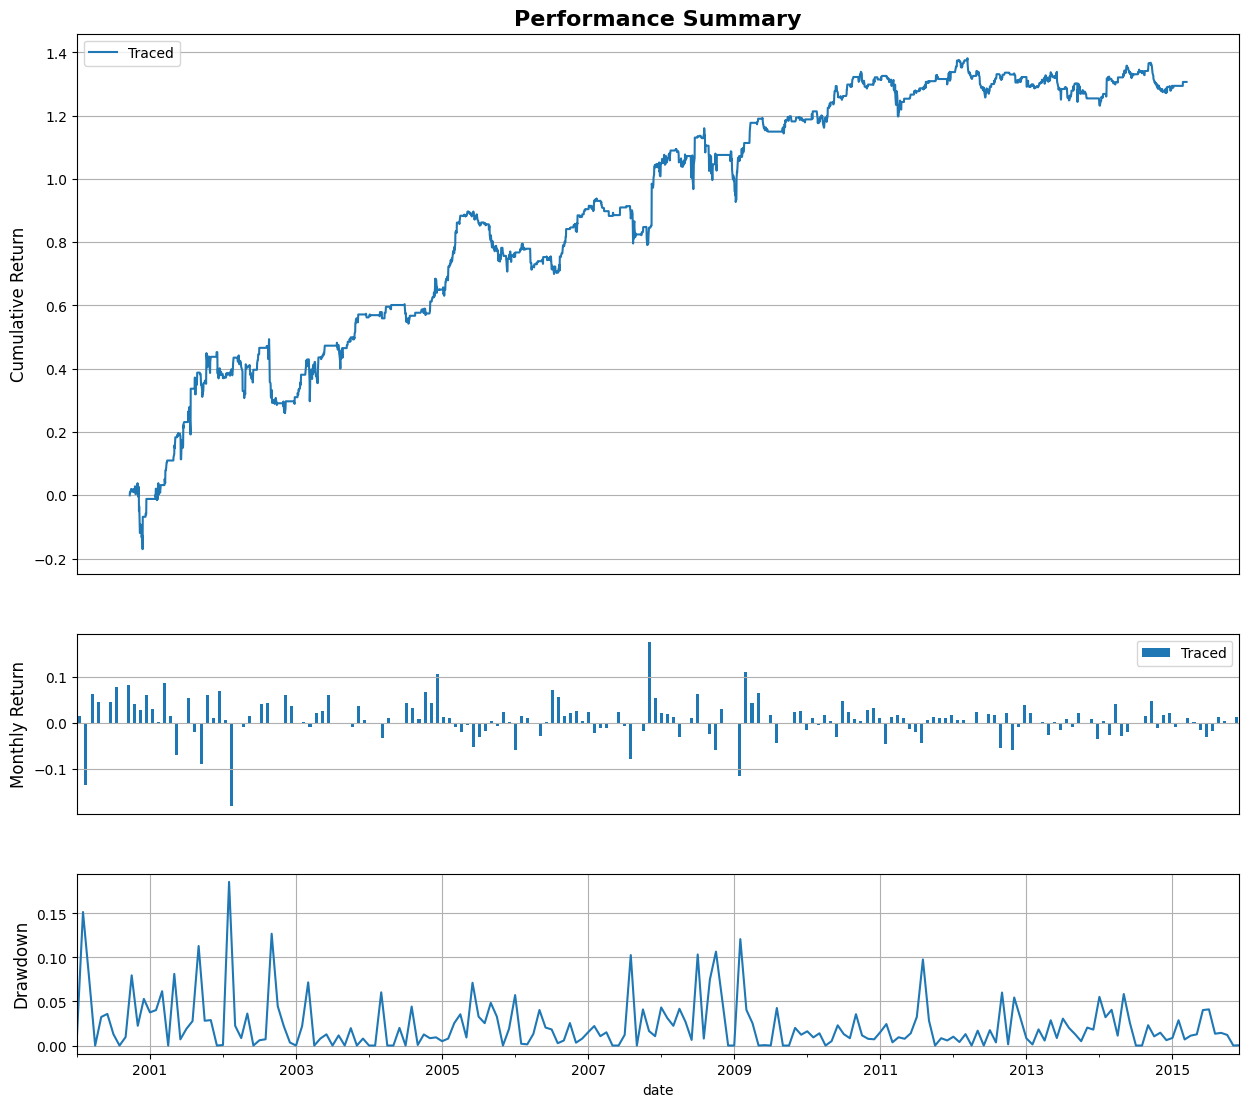

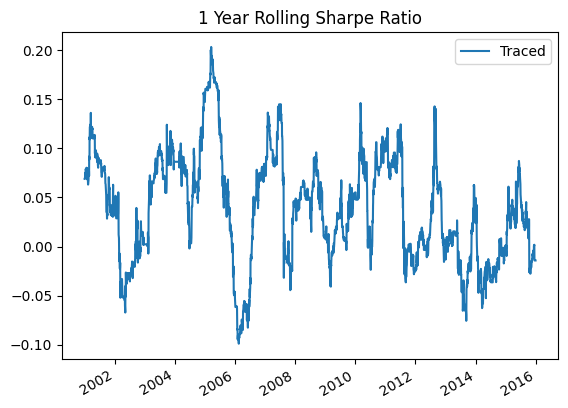

TypeError: get_analytics() missing 1 required positional argument: 'holdings'

In [18]:
alphas = [Traced(90, 10, 2.25, 1.75, 3.5)]
returns, holdings = backtester_15y.backtest(alphas, processes=None)
metrics.summary_plot(returns, source=['Traced'])
get_rolling_sharpe(returns)
get_analytics(returns, holdings)

In [ ]:
class Traced_Hurst(AbstractAlpha):
    def __init__(self, reset, npairs, enter, exit, stop, hurst):
        self.name = 'Traced_Hurst'
        self.lookback = reset
        self.factor_list = ['close']
        self.universe_size = 500
        self.pairs = None
        self.print = False
        self.reset = reset
        self.npairs = npairs
        self.enter = enter
        self.exit = exit
        self.stop = stop
        self.holdings = np.zeros(self.universe_size)
        self.period = 1
        self.day = 0
        self.day_counter = 0
        self.factors = ['Zscore', 'Close Prices', 'Spread']
        self.factor_data = {factor:pd.DataFrame(np.zeros((self.reset, self.npairs))) for factor in self.factors}
        self.hurst_cutoff = hurst # MAXIMUM Hurst Exponent. Recall 0.5 means that the series reflects brownian motion
    
    def hurst(self, p):
        # print(len(p))
        lags = range(2, min(len(p) - 2, 75))
        variancetau, tau = [], []
        for lag in lags:
            tau.append(lag) # Write the different lags into a vector to compute a set of tau or lags
            # Compute the log returns on all days, then compute the variance on the difference in log returns
            # call this pp or the price difference
            pp = np.subtract(p[lag:], p[:-lag])
            variancetau.append(np.var(pp))
        # we now have a set of tau or lags and a corresponding set of variances.
        # plot the log of those variance against the log of tau and get the slope
        m = np.polyfit(np.log10(tau), np.log10(variancetau), 1)
        hurst = m[0] / 2
        return hurst
    
    def zscore(self, series):
        return (series - series.mean()) / np.std(series)
    
    def form_pairs(self, df):
        df = pd.DataFrame(df).dropna()
        n = df.shape[1]
        # obtain transformed data and clusters using above functions
        transformed_data = self.reduce_dimensionality(df)
        labels = self.cluster_optics(transformed_data)
        pvalue_matrix = np.ones((n, n))
        keys = df.keys()
        pairs = []
        pairsDict = {} #maps from pvalue to pair
        for i in range(n):
            for j in range(i + 1, n):
                if labels[i] != -1 and labels[j] != -1 and labels[i] == labels[j]:
                    S1 = df[keys[i]]
                    S2 = df[keys[j]]
                    result = coint(S1, S2)
                    pvalue = result[1]
                    pvalue_matrix[i, j] = pvalue
                    # used a hashmap, sorted keys (pvalues) in ascending order in order
                    # to get the smallest pvalues
                    if pvalue < 0.05:
                        display(S1)
                        h_exp = self.hurst(list(S1-S2))
                        #print(h_exp)
                        # if h_exp < self.hurst_cutoff:
                        pairsDict[(i,j)] = pvalue
        
        # sort the pairs by lowest p-value
        keys, values = list(pairsDict.keys()), list(pairsDict.values())
        sorted_value_index = np.argsort(values)
        sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
        # a stock should only be included once in our holdings to prevent mishaps
        new_dict, seen = {}, set()
        for (i, j) in sorted_dict:
            if i not in seen and j not in seen:
                new_dict[(i, j)] = sorted_dict[(i,j)]
                seen.add(i)
                seen.add(j)
        # obtain top npairs pairs if possible
        pairs = list(new_dict.keys()) if len(new_dict) < self.npairs else list((new_dict.keys()))[0:self.npairs]
        return pairs
    
    def reduce_dimensionality(self, df: pd.DataFrame) -> pd.DataFrame:
        rets = df.pct_change().dropna()
        rets = rets.T
        pca = PCA(n_components = 0.9, svd_solver='full')
        transformed_data = pca.fit_transform(rets)
        return transformed_data
    
    def cluster_optics(self, transformed_data: array_1d) -> array_1d:
        optics = OPTICS(min_samples = 2)
        labels = optics.fit_predict(transformed_data)
        return labels
    
    def make_factors(self):
        self.factor_data = {factor:pd.DataFrame(np.zeros((self.reset, self.npairs))) for factor in self.factors}
        for factor in self.factor_data:
            if(len(self.pairs) > 0):
                self.factor_data[factor] = self.factor_data[factor].set_axis(self.pairs, axis="columns")
                new_axis = [i for i in range(self.reset)]
                self.factor_data[factor] = self.factor_data[factor].set_axis(new_axis, axis="rows")
                self.factor_data[factor] = self.factor_data[factor].rename_axis(f"{factor} of Pairs", axis="columns")
    
    def generate_day(self, day, data):
        # print factor data if its the end of the window
        if self.day == self:
            self.day = 0
            if self.print:
                for factor in self.factors:
                    print(f"Trading Window {self.period}: {factor}")
                    print(self.factor_data[factor].to_markdown())
                    print()
            self.period += 1
        # creating new pairs
        
        if self.day_counter == 0:
            self.day_counter = self.reset
            self.holdings = np.zeros(self.universe_size)
            self.pairs = self.form_pairs(data['close'])
            self.factor_data = {factor:pd.DataFrame(np.zeros((self.reset, self.npairs))) for factor in self.factors}
            self.make_factors()
        
        data = pd.DataFrame(data['close']).fillna(method="ffill").fillna(method="bfill")
        # print(len(data))

        for p in self.pairs:
            # *** FACTOR DATA *** #
            FIRST, SECOND = p[0], p[1]
            spread = data[FIRST] - data[SECOND]
            z_score = self.zscore(spread).tail(1).values[0]
            diff = spread[day]
            close_price = ({round(data[p[0]][day], 2)} , {round(data[p[1]][day], 2)})
            for factor in self.factors:
                # add to dataframes
                if factor == 'Zscore':
                    if z_score >= self.enter and z_score < self.stop:
                        # update current trade status
                        self.factor_data[factor][p][self.day] = f"OPEN {round(z_score, 2)}"
                    # exit the trade; dont increment anything
                    elif abs(z_score) <= self.exit:
                        self.factor_data[factor][p][self.day] = f"CLOSED {round(z_score, 2)}"
                    # enter the trade; long the FIRST, short SECOND
                    elif z_score <= -self.enter and z_score >= -self.stop:
                        self.factor_data[factor][p][self.day] = f"OPEN {round(z_score, 2)}"
                elif factor == 'Close Prices':
                    self.factor_data[factor][p][self.day] = close_price
                    # print(self.factor_data[factor][p][day])
                elif factor == 'Spread':
                    self.factor_data[factor][p][self.day] = round(diff, 2)
            if z_score >= self.enter and z_score <= self.stop:
                    self.holdings[FIRST] = -1
                    self.holdings[SECOND] = 1
            # exit the trade
            elif abs(z_score) < self.exit:
                self.holdings[FIRST] = 0
                self.holdings[SECOND] = 0
            # ensure that the pair is still cointegrated, otherwise eat the losses before it gets worse
            elif abs(z_score) > self.stop:
                temp = data.dropna()
                S1, S2 = temp[FIRST], temp[SECOND]
                result = coint(S1, S2)
                pvalue = result[1]
                if pvalue >= 0.05:
                    self.holdings[FIRST] = 0
                    self.holdings[SECOND] = 0
                    self.pairs.remove(p)
            # enter the trade; long the FIRST, short SECOND
            elif z_score <= -self.enter and z_score >= -self.stop:
                self.holdings[FIRST] = 1
                self.holdings[SECOND] = -1
        # at the end of the trading day, decrement day_counter
        self.day += 1
        self.day_counter -= 1
        return op.weight(self.holdings)

In [ ]:
alphas = [Traced_Hurst(90, 10, 2.25, 1.75, 3.5, 1)]
returns, holdings = backtester_15y.backtest(alphas, processes=None)
metrics.summary_plot(returns, source=['Traced_Hurst'])
get_rolling_sharpe(returns)
get_analytics(returns, holdings)

# Conclusion

Our main results are as follows:



## References

[https://www.investopedia.com/terms/p/pairstrade.asp](https://www.investopedia.com/terms/p/pairstrade.asp)

[https://www.investopedia.com/terms/m/market-neutral-fund.asp](https://www.investopedia.com/terms/m/market-neutral-fund.asp)

[https://en.wikipedia.org/wiki/Long-Term_Capital_Management#Riskier_investments_starting_in_1997](https://en.wikipedia.org/wiki/Long-Term_Capital_Management#Riskier_investments_starting_in_1997)

[https://corporatefinanceinstitute.com/resources/wealth-management/pairs-trading/](https://corporatefinanceinstitute.com/resources/wealth-management/pairs-trading/)

[https://www.fidelity.com/learning-center/trading-investing/trading/pairs-trading](https://www.fidelity.com/learning-center/trading-investing/trading/pairs-trading)

[https://www.investopedia.com/terms/r/relativestrength.asp](https://www.investopedia.com/terms/r/relativestrength.asp)

[https://algotrading101.com/learn/pairs-trading-guide/](https://algotrading101.com/learn/pairs-trading-guide/)

[https://www.quantifiedstrategies.com/pair-trading-strategy/](https://www.quantifiedstrategies.com/pair-trading-strategy/)

[https://hudsonthames.org/an-introduction-to-cointegration/](https://hudsonthames.org/an-introduction-to-cointegration/)

[https://israeldi.github.io/coursework/EECS545/545_Final_Project.pdf](https://israeldi.github.io/coursework/EECS545/545_Final_Project.pdf)

[https://builtin.com/data-science/step-step-explanation-principal-component-analysis](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)

[https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556](https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556)

[https://www.statsmodels.org/dev/generated/statsmodels.multivariate.pca.PCA.html](https://www.statsmodels.org/dev/generated/statsmodels.multivariate.pca.PCA.html)

[https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

[https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html)

[https://medium.com/@ashwin8april/dimensionality-reduction-and-visualization-using-pca-principal-component-analysis-8489b46c2ae0](https://medium.com/@ashwin8april/dimensionality-reduction-and-visualization-using-pca-principal-component-analysis-8489b46c2ae0)

[https://www.researchgate.net/publication/305808800_Pairs_Trading_Different_Weights_Methods_and_Markets](https://www.researchgate.net/publication/305808800_Pairs_Trading_Different_Weights_Methods_and_Markets)